##### Uniform distribution of SNR
##### SNR: 75 - 500

In [1]:
# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split
import sys
import random 

2023-11-10 12:22:19.614365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 12:22:20.479007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/abraham/miniconda3/envs/tf/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.1


np.sum(a) =  100000


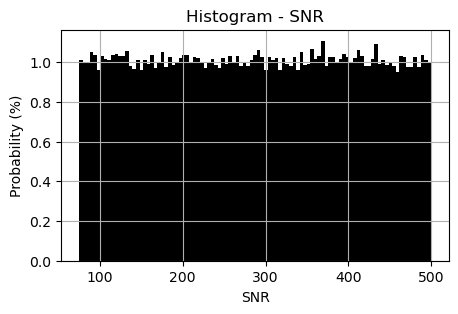

In [2]:
random_generator = np.random.default_rng()
SNR_array = random_generator.uniform(75,500,100000)

plt.figure(figsize=(5, 3))
bins = np.linspace(75,500,100)
def plot_hist(array,bins,plot_title = 'Histogram',xaxis_title='x'):
    plt.rcParams['figure.dpi'] = 400
    a,*_ = np.histogram(array, bins=bins)
    # print('a = ',a)
    print('np.sum(a) = ', np.sum(a))
    a_percent = (a/np.sum(a))*100
    # print('a_percent = ',a_percent)

    plt.stairs(a_percent, bins, baseline=0,fill=True,color='black')
    plt.xlabel(str(xaxis_title))
    # plt.xscale("log")
    plt.ylabel('Probability (%)')
    plt.title(str(plot_title))
    plt.grid(True)
    plt.show()
plot_hist(SNR_array,bins,plot_title = 'Histogram - SNR',xaxis_title='SNR')

# Load Simulation Dataset

In [3]:
# 1. Load Dataset
## Load Train Set
train_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled5.npy'
train_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_5.npy'
train_lc = np.load(train_lc_dir)
train_shape = np.load(train_shape_dir)
# Check equality of number of dataset
if len(train_lc)==len(train_shape):
    print("Train Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: Train Set: No. of LC != No. of shapes")

## Load Validation Set
vald_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled4.npy'
vald_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_4.npy'
vald_lc = np.load(vald_lc_dir)
vald_shape = np.load(vald_shape_dir)
# Check equality of nuftmber of dataset
if len(vald_lc)==len(vald_shape):
    print("Vald Set: No. of LC = No. of shapes")
else:
    sys.exit("Vald Set: No. of LC = No. of shapes")

Train Set: No. of LC = No. of shapes
Vald Set: No. of LC = No. of shapes


In [4]:
# 2. Normalize the image, convert to opacity map
## Train Set
train_shape = train_shape/np.amax(train_shape)
train_shape_where_0 = np.where(train_shape == 0)
train_shape_where_1 = np.where(train_shape == 1)
train_shape[train_shape_where_0] = 1  # 1 represent the shape (1 opacity)
train_shape[train_shape_where_1] = 0  # 0 represent background (0 opacity)

## Valdn Set
vald_shape = vald_shape/np.amax(vald_shape)
vald_shape_where_0 = np.where(vald_shape == 0)
vald_shape_where_1 = np.where(vald_shape == 1)
vald_shape[vald_shape_where_0] = 1  # 1 represent the shape (1 opacity)
vald_shape[vald_shape_where_1] = 0  # 0 represent background (0 opacity)
print("Normalized the shape")


Normalized the shape


In [5]:
# 2. Normalize the lightcurves
## - Train Set
train_lc_scaled = np.zeros(train_lc.shape)
for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled[i] = (train_lc[i] - np.amin(train_lc[i]))/(np.amax(train_lc[i]) - np.amin(train_lc[i]))

## - Vald Set
vald_lc_scaled = np.zeros(vald_lc.shape)
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled[i] = (vald_lc[i] - np.amin(vald_lc[i]))/(np.amax(vald_lc[i]) - np.amin(vald_lc[i]))
print("Normalized the light curves")


Normalized the light curves


In [6]:
# Add flat line towards left and right of dip
# 10 data points on each side
# 3. Extend the lightcurves
## - Train Set
train_lc_scaled_append = np.ones((train_lc.shape[0],120))
print('train_lc_scaled_append.shape = ',train_lc_scaled_append.shape)
print("len(train_lc_scaled_append[0,10:110]) = ",len(train_lc_scaled_append[0,10:110]))

for i in np.arange(len(train_lc_scaled)):
    train_lc_scaled_append[i,10:110] = train_lc_scaled[i]

## - Vald Set
vald_lc_scaled_append = np.ones((vald_lc.shape[0],120))
for i in np.arange(len(vald_lc_scaled)):
    vald_lc_scaled_append[i,10:110] = vald_lc_scaled[i]
print("Extended the light curves")

train_lc_scaled_append.shape =  (132136, 120)
len(train_lc_scaled_append[0,10:110]) =  100
Extended the light curves


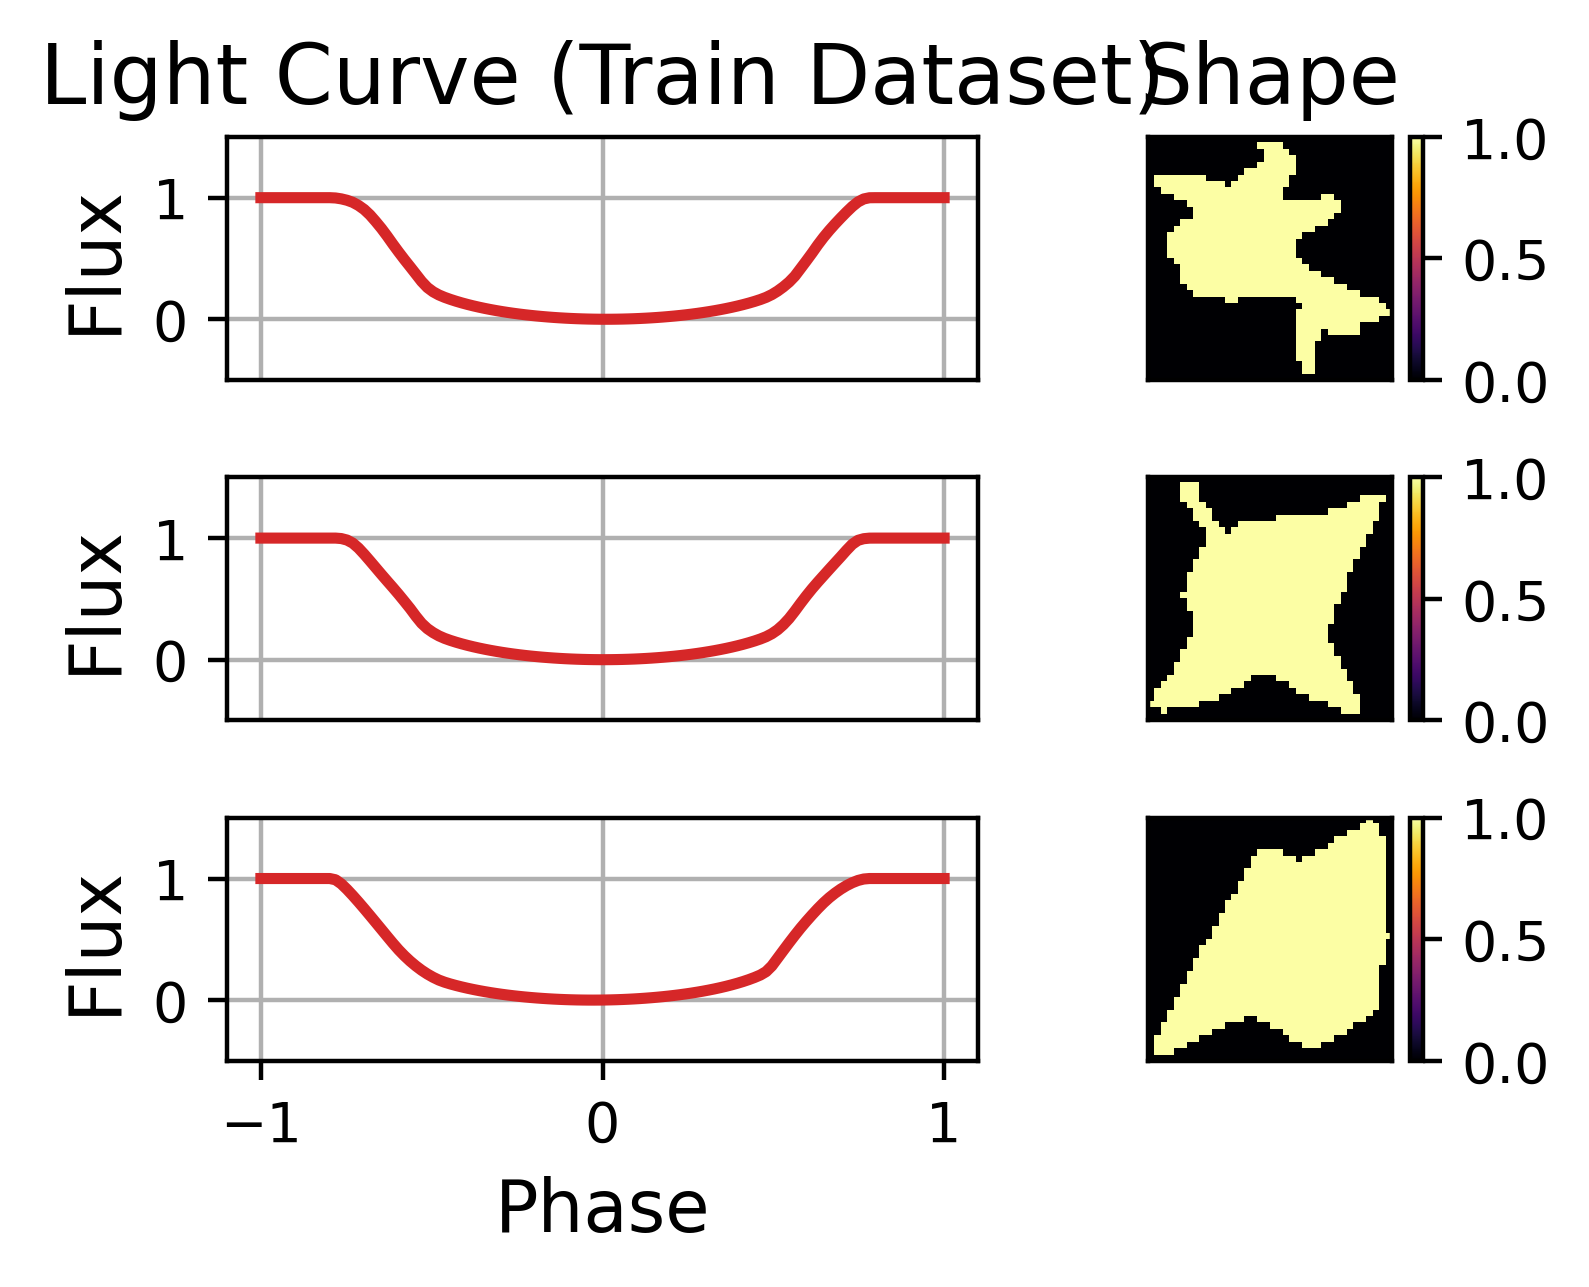

In [7]:
# Verification
# Plot - Train LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (Train Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(train_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(train_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, train_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

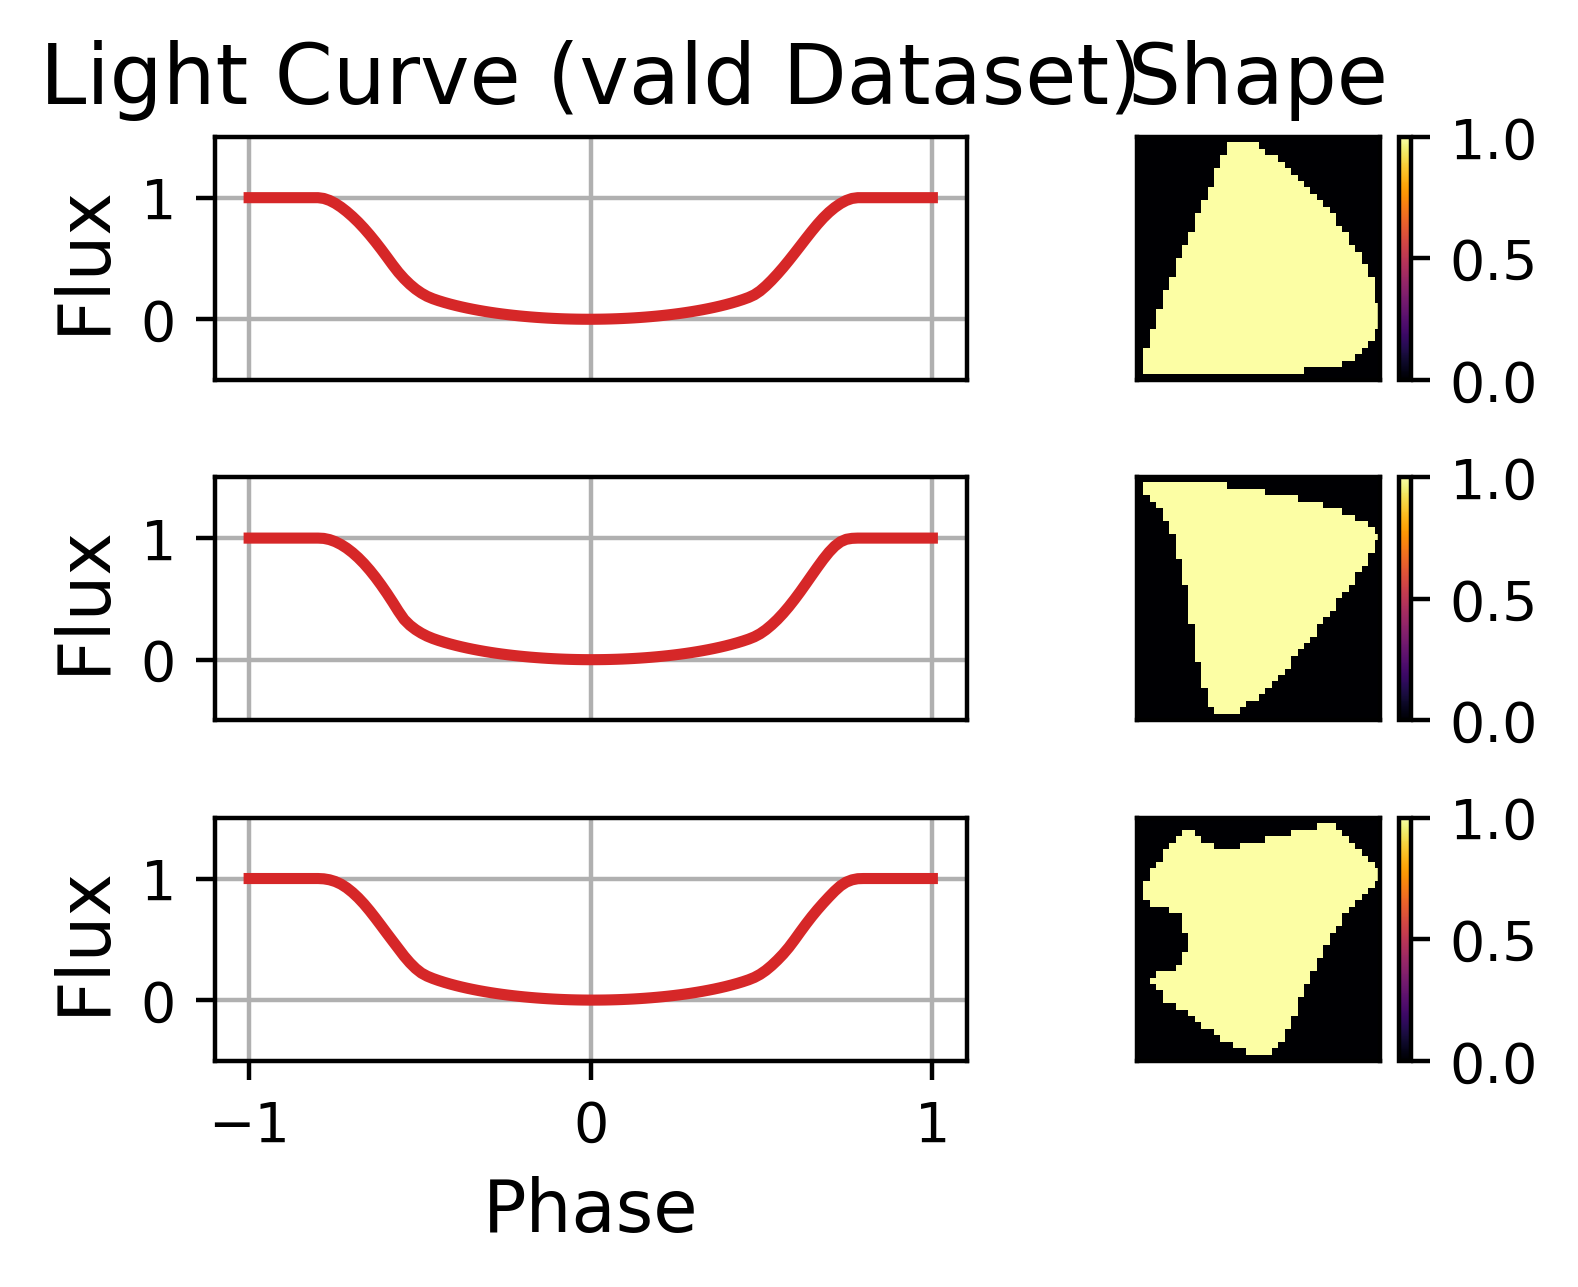

In [8]:
# Verification
# Plot - vald LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})

ax[0][1].set_title('Shape',size=15)
ax[0][0].set_title('Light Curve (vald Dataset)',size=15)
ax[num-1][0].set_xlabel('Phase',size=13)
ph = np.linspace(-1,1,len(vald_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(vald_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(vald_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, vald_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

# Add noise

np.sum(a) =  132136


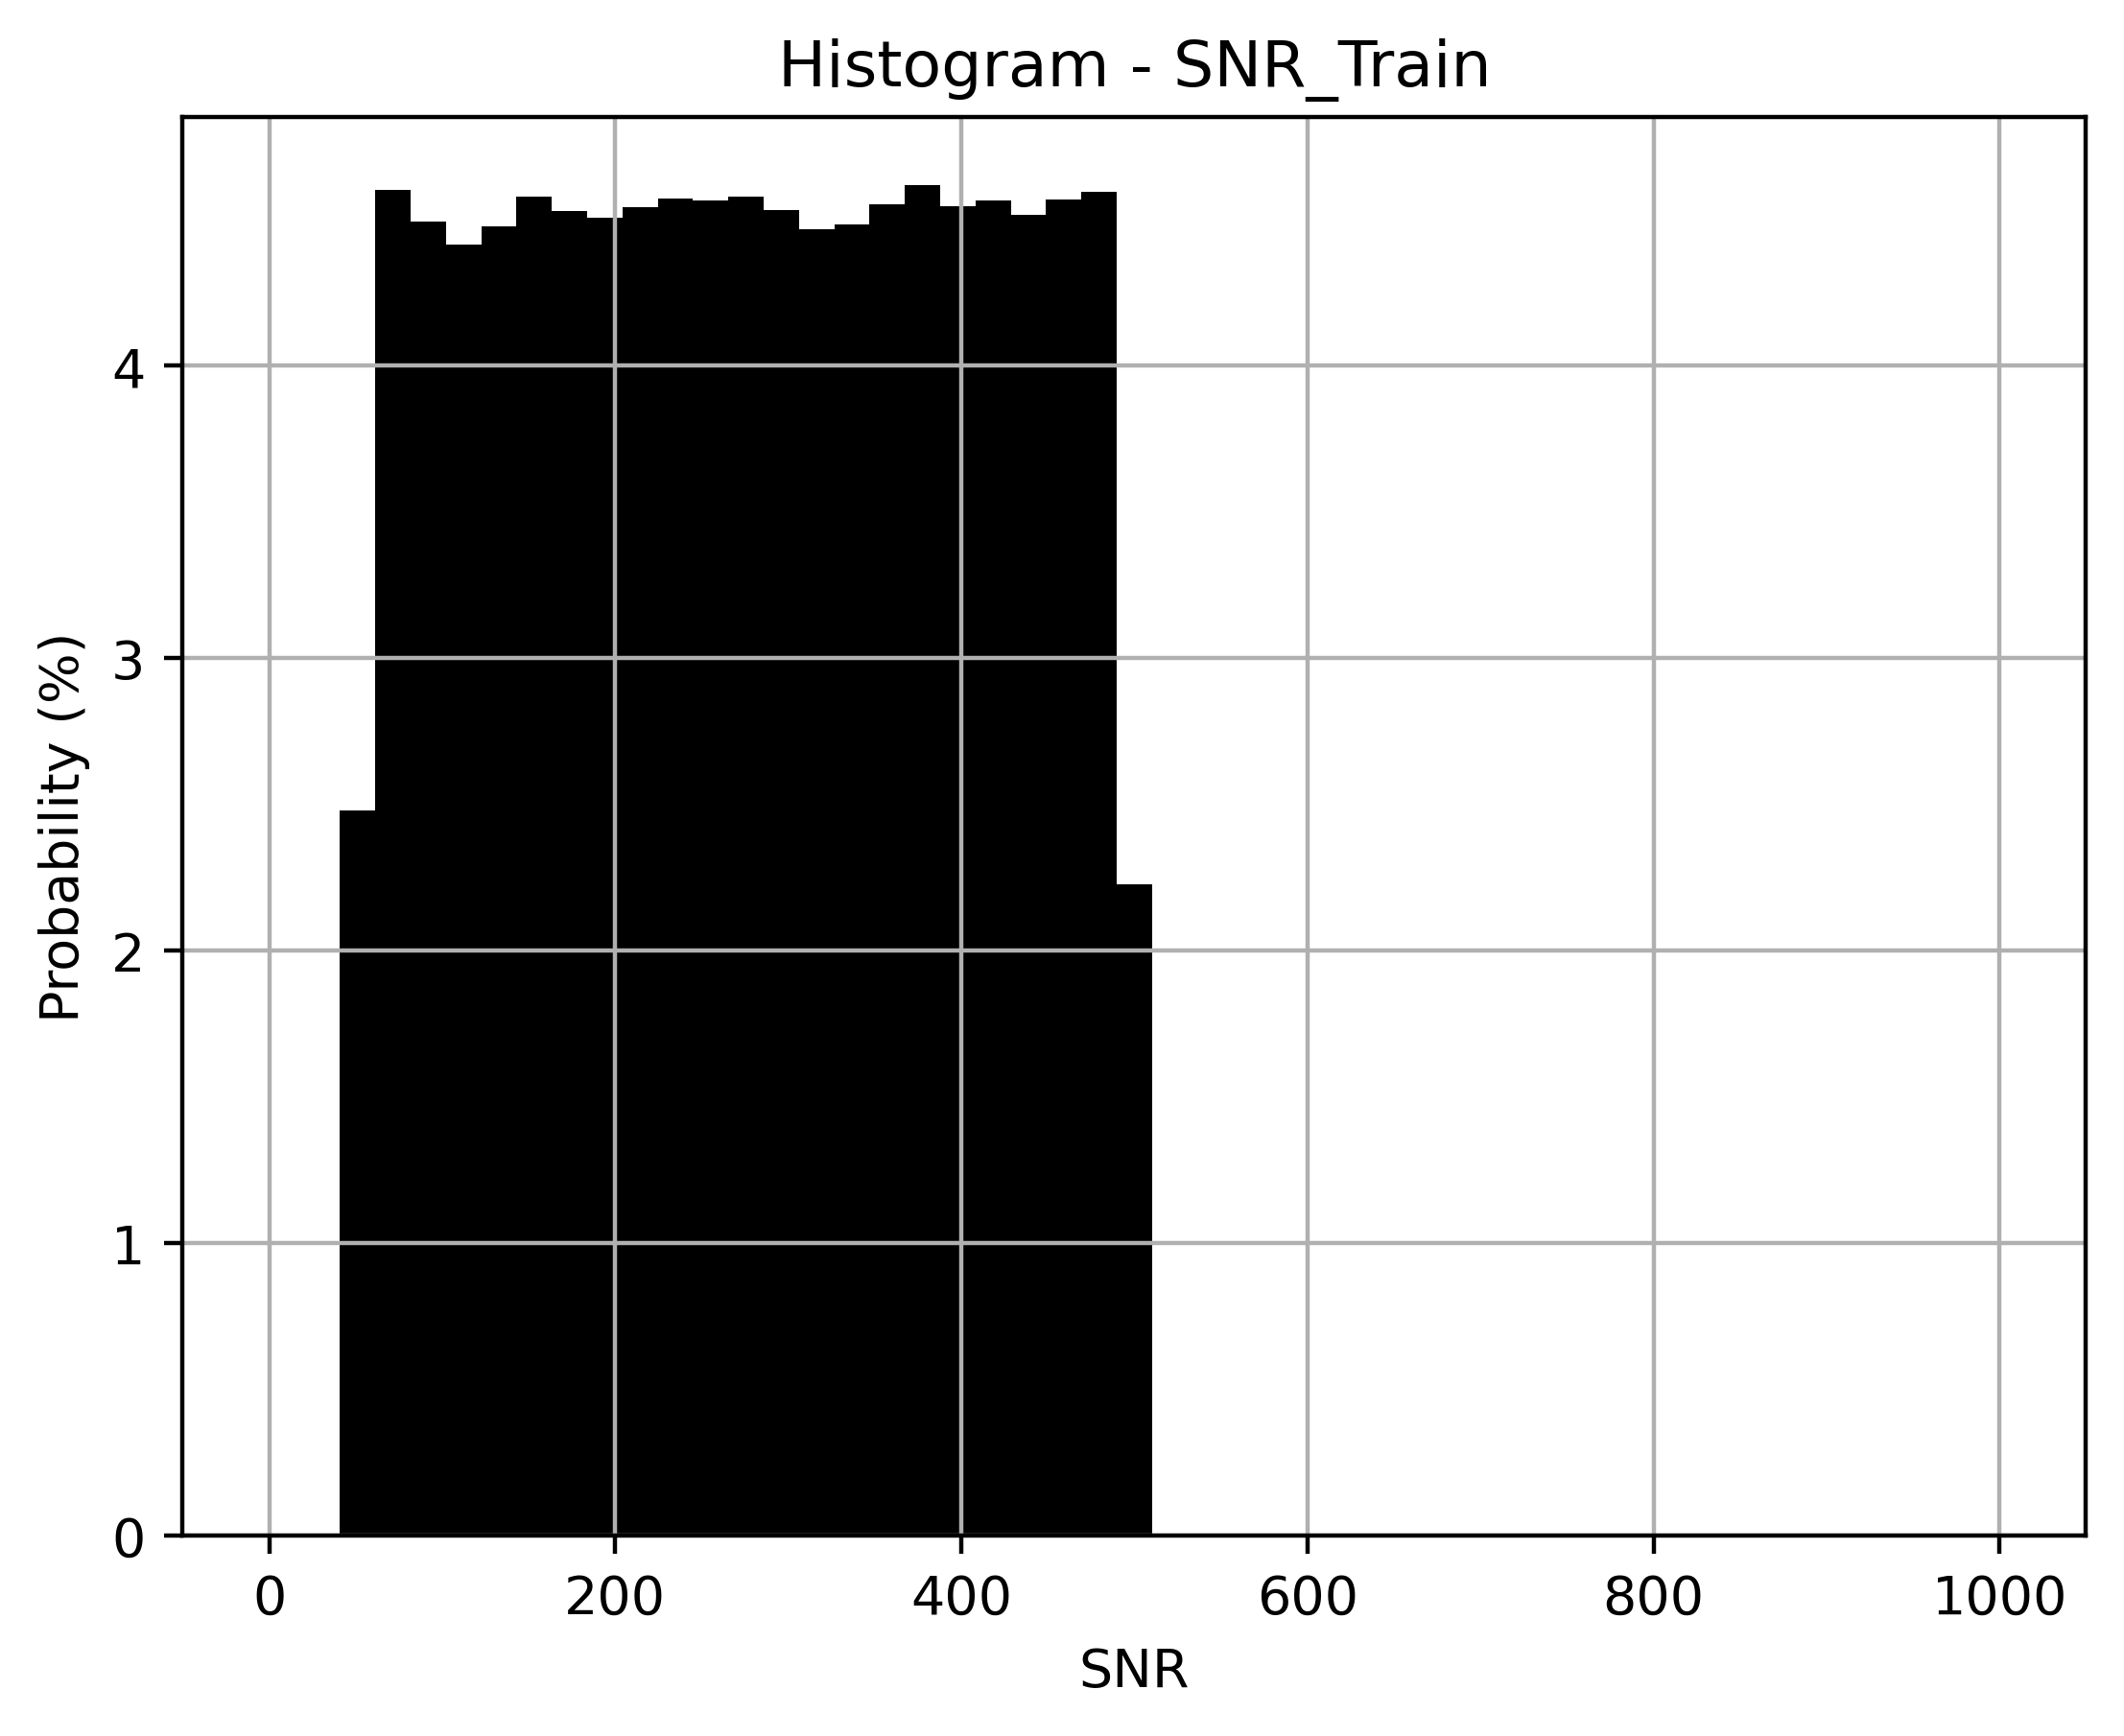

std_dev_train[0] =  0.002313908470270021
np.sum(a) =  1000


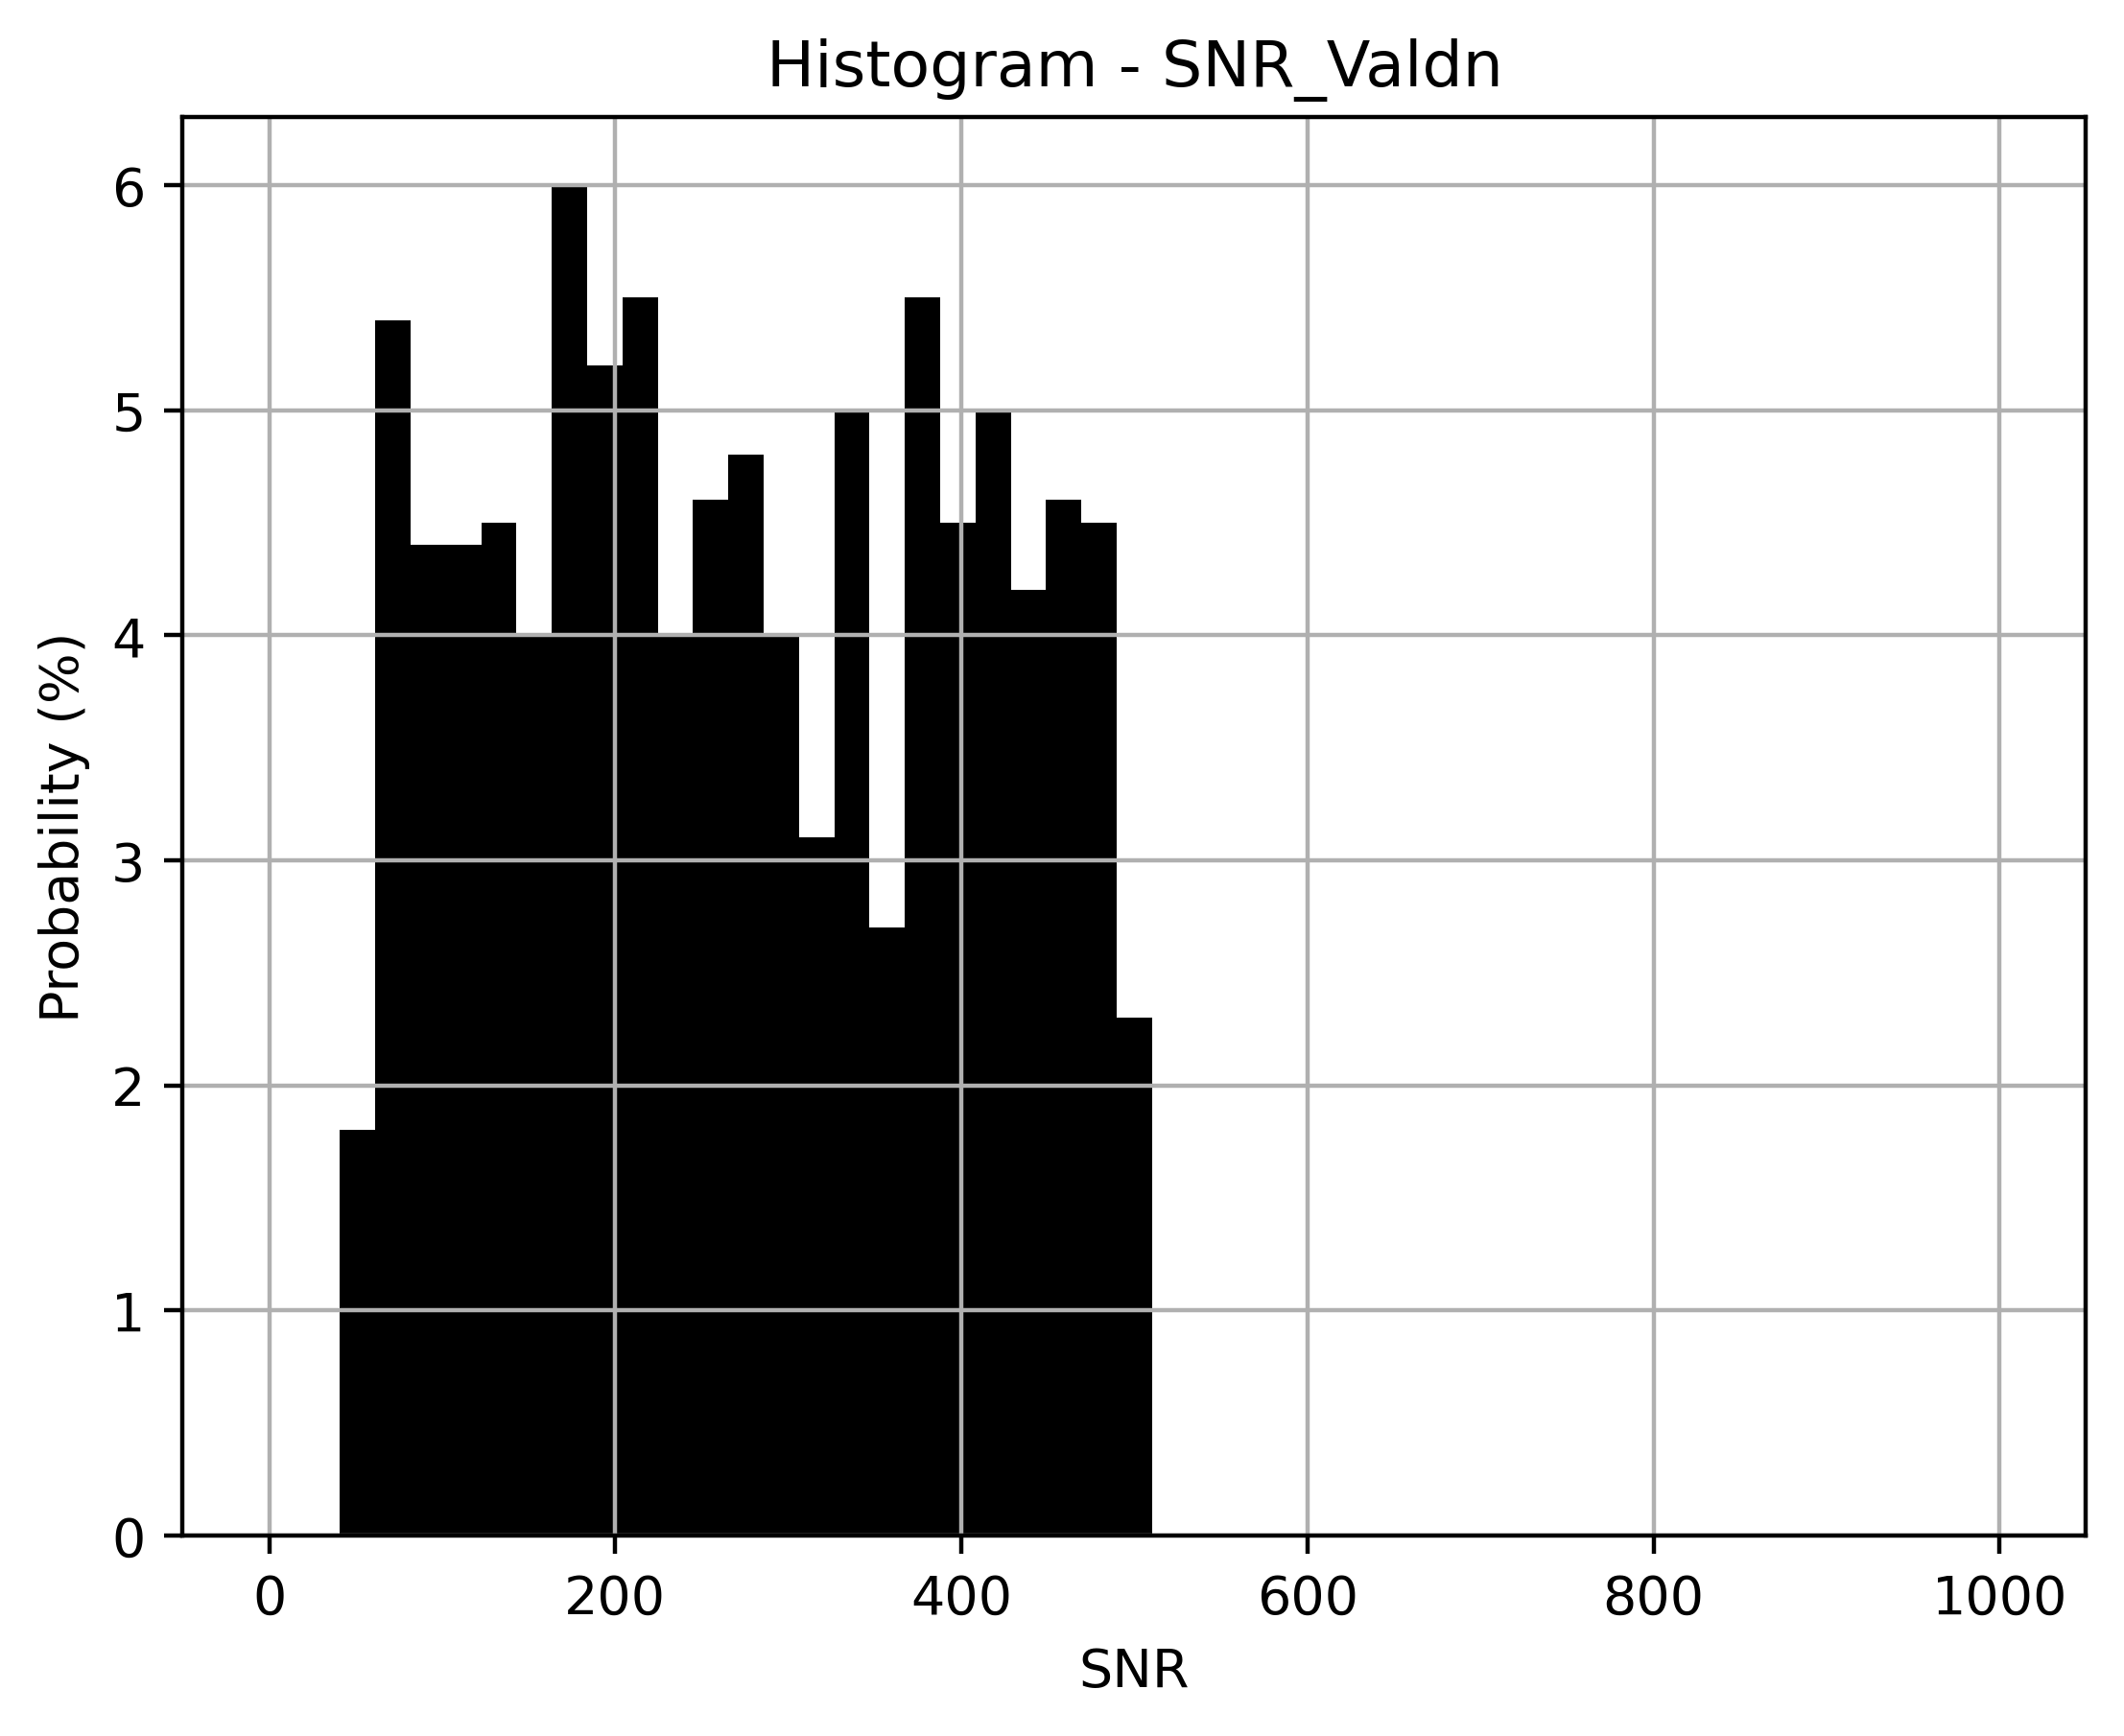

std_dev_vald[0] =  0.0024821845276003897


In [9]:
random_generator = np.random.default_rng()
SNR_array_train = random_generator.uniform(50,500,len(train_lc_scaled_append))
bins = np.linspace(0,1000,50)
plot_hist(SNR_array_train,bins,plot_title = 'Histogram - SNR_Train',xaxis_title='SNR')
std_dev_train = 1/SNR_array_train
del SNR_array_train
print('std_dev_train[0] = ',std_dev_train[0])

SNR_array_vald = random_generator.uniform(50,500,len(vald_lc_scaled_append))
bins = np.linspace(0,1000,50)
plot_hist(SNR_array_vald,bins,plot_title = 'Histogram - SNR_Valdn',xaxis_title='SNR')
std_dev_vald = 1/SNR_array_vald
del SNR_array_vald
print('std_dev_vald[0] = ',std_dev_vald[0])


np.sum(a) =  130808


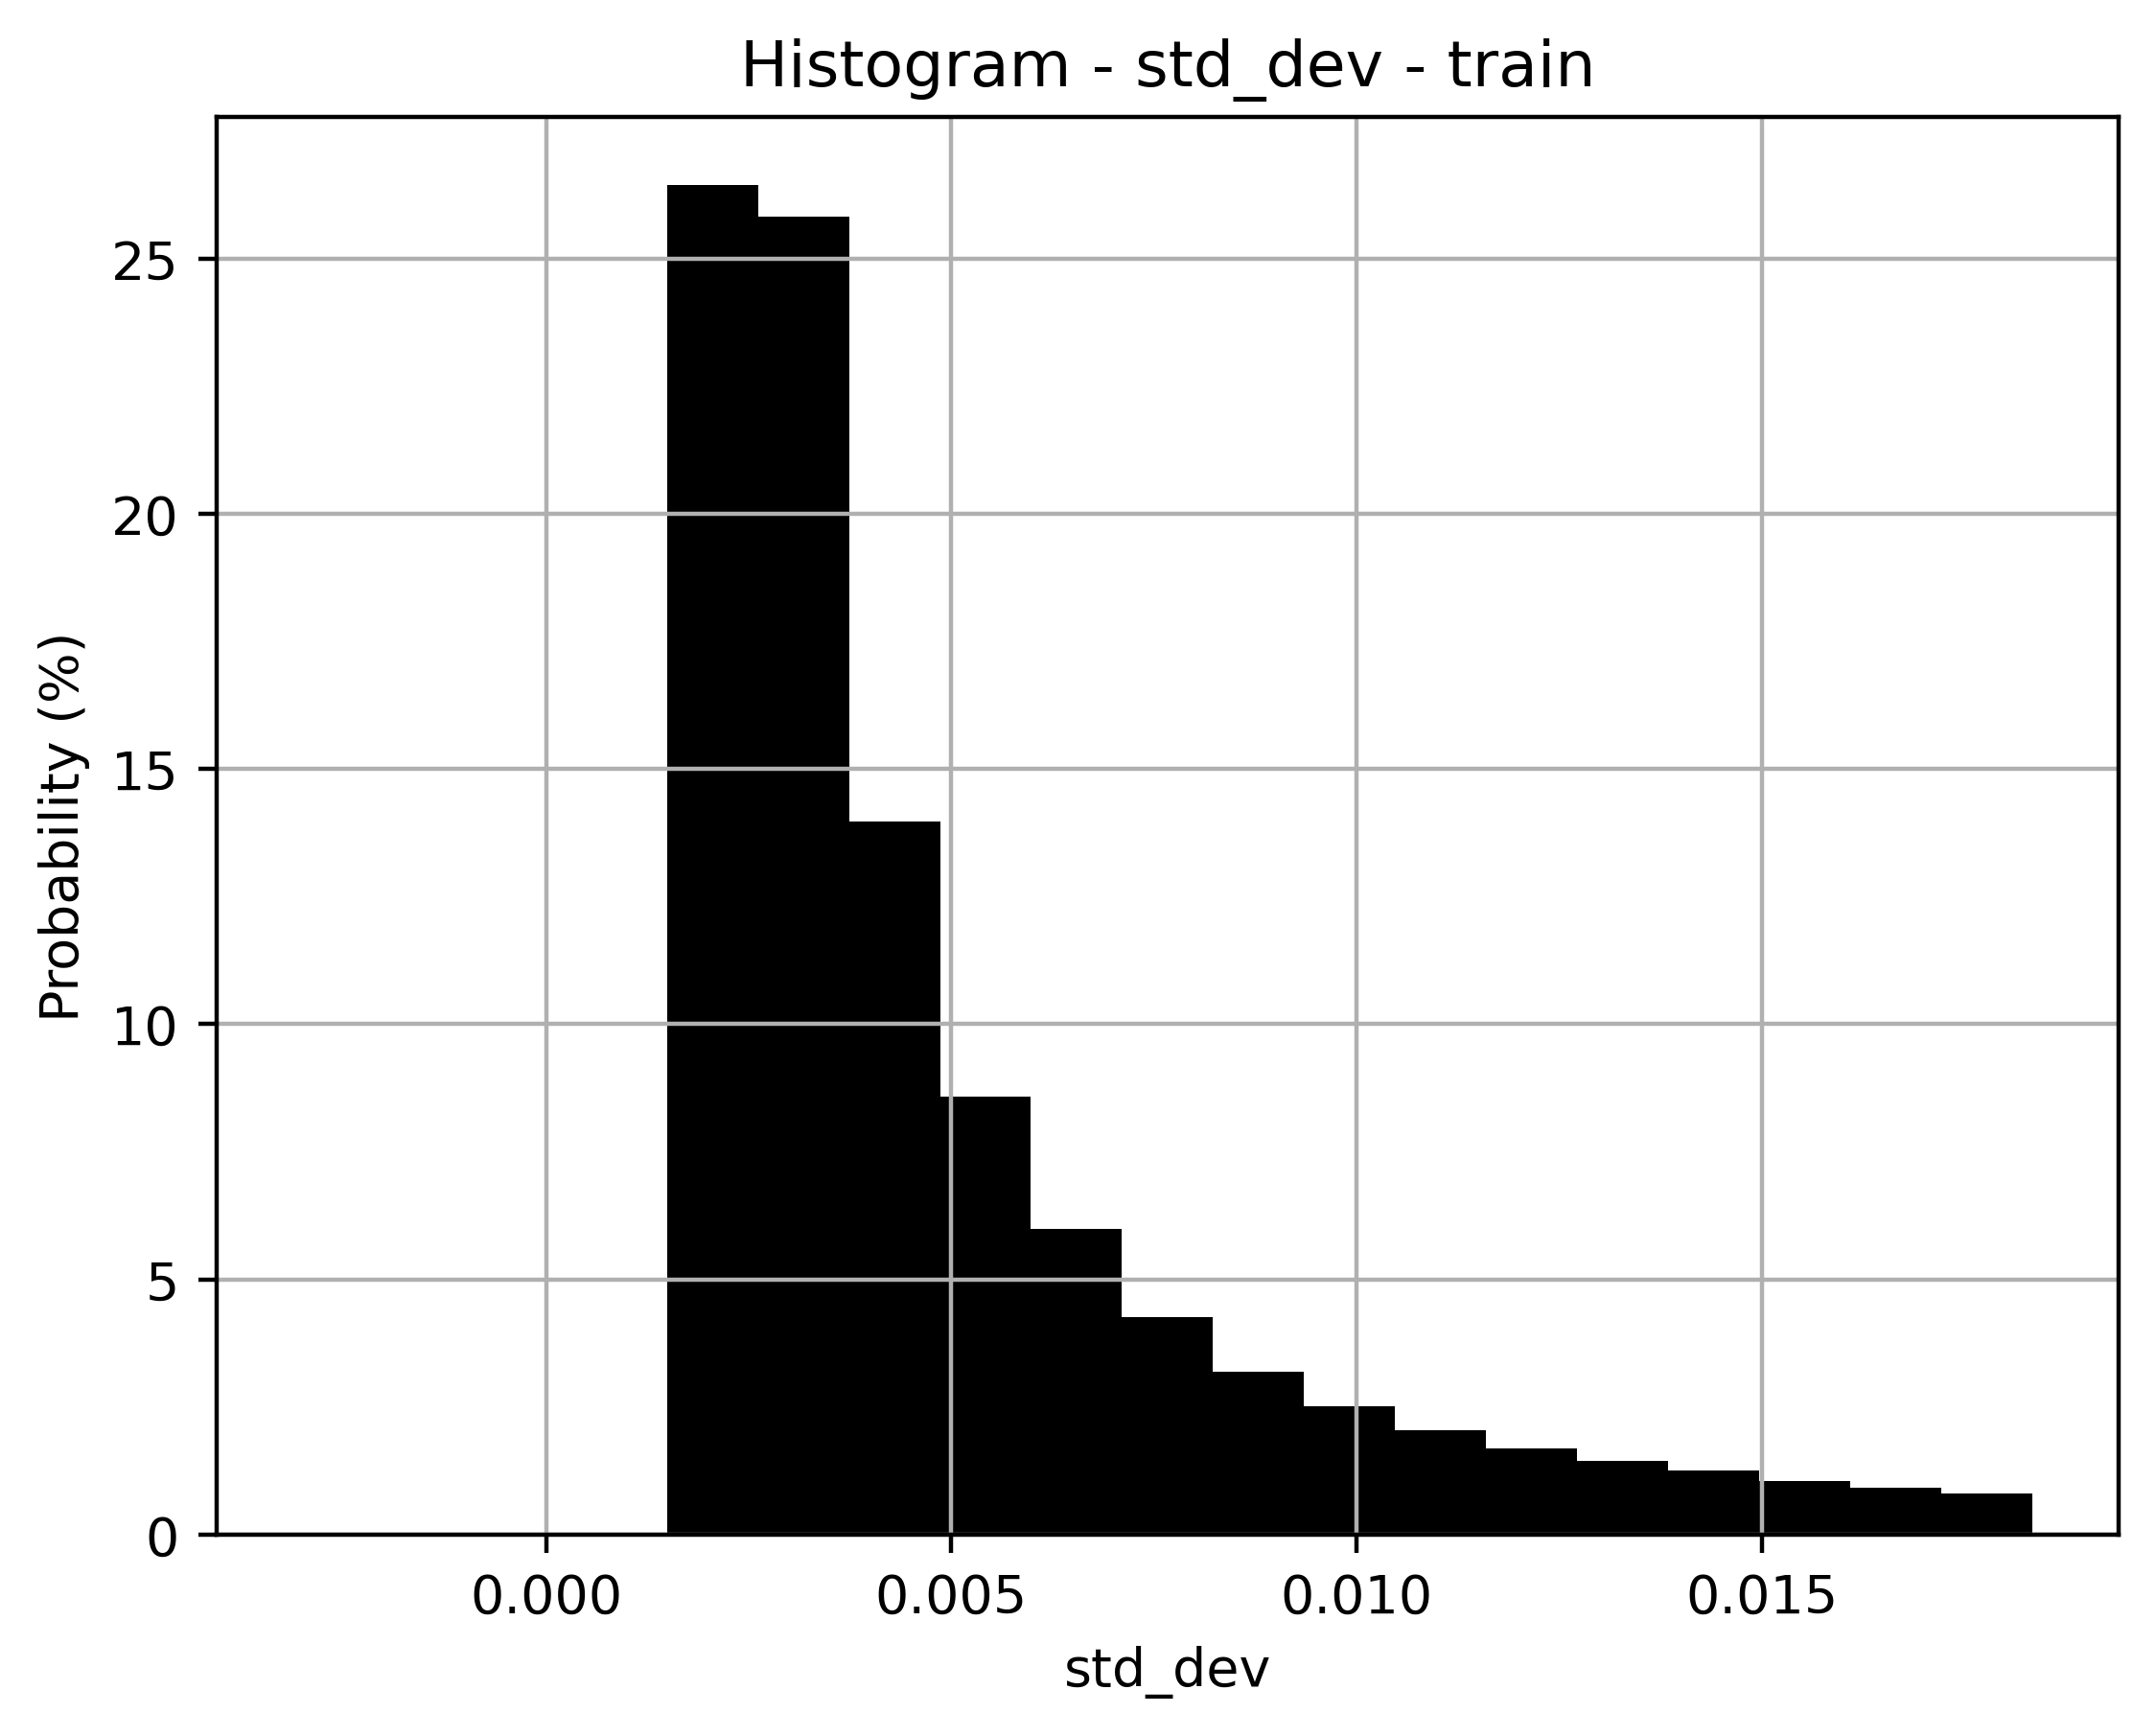

np.sum(a) =  988


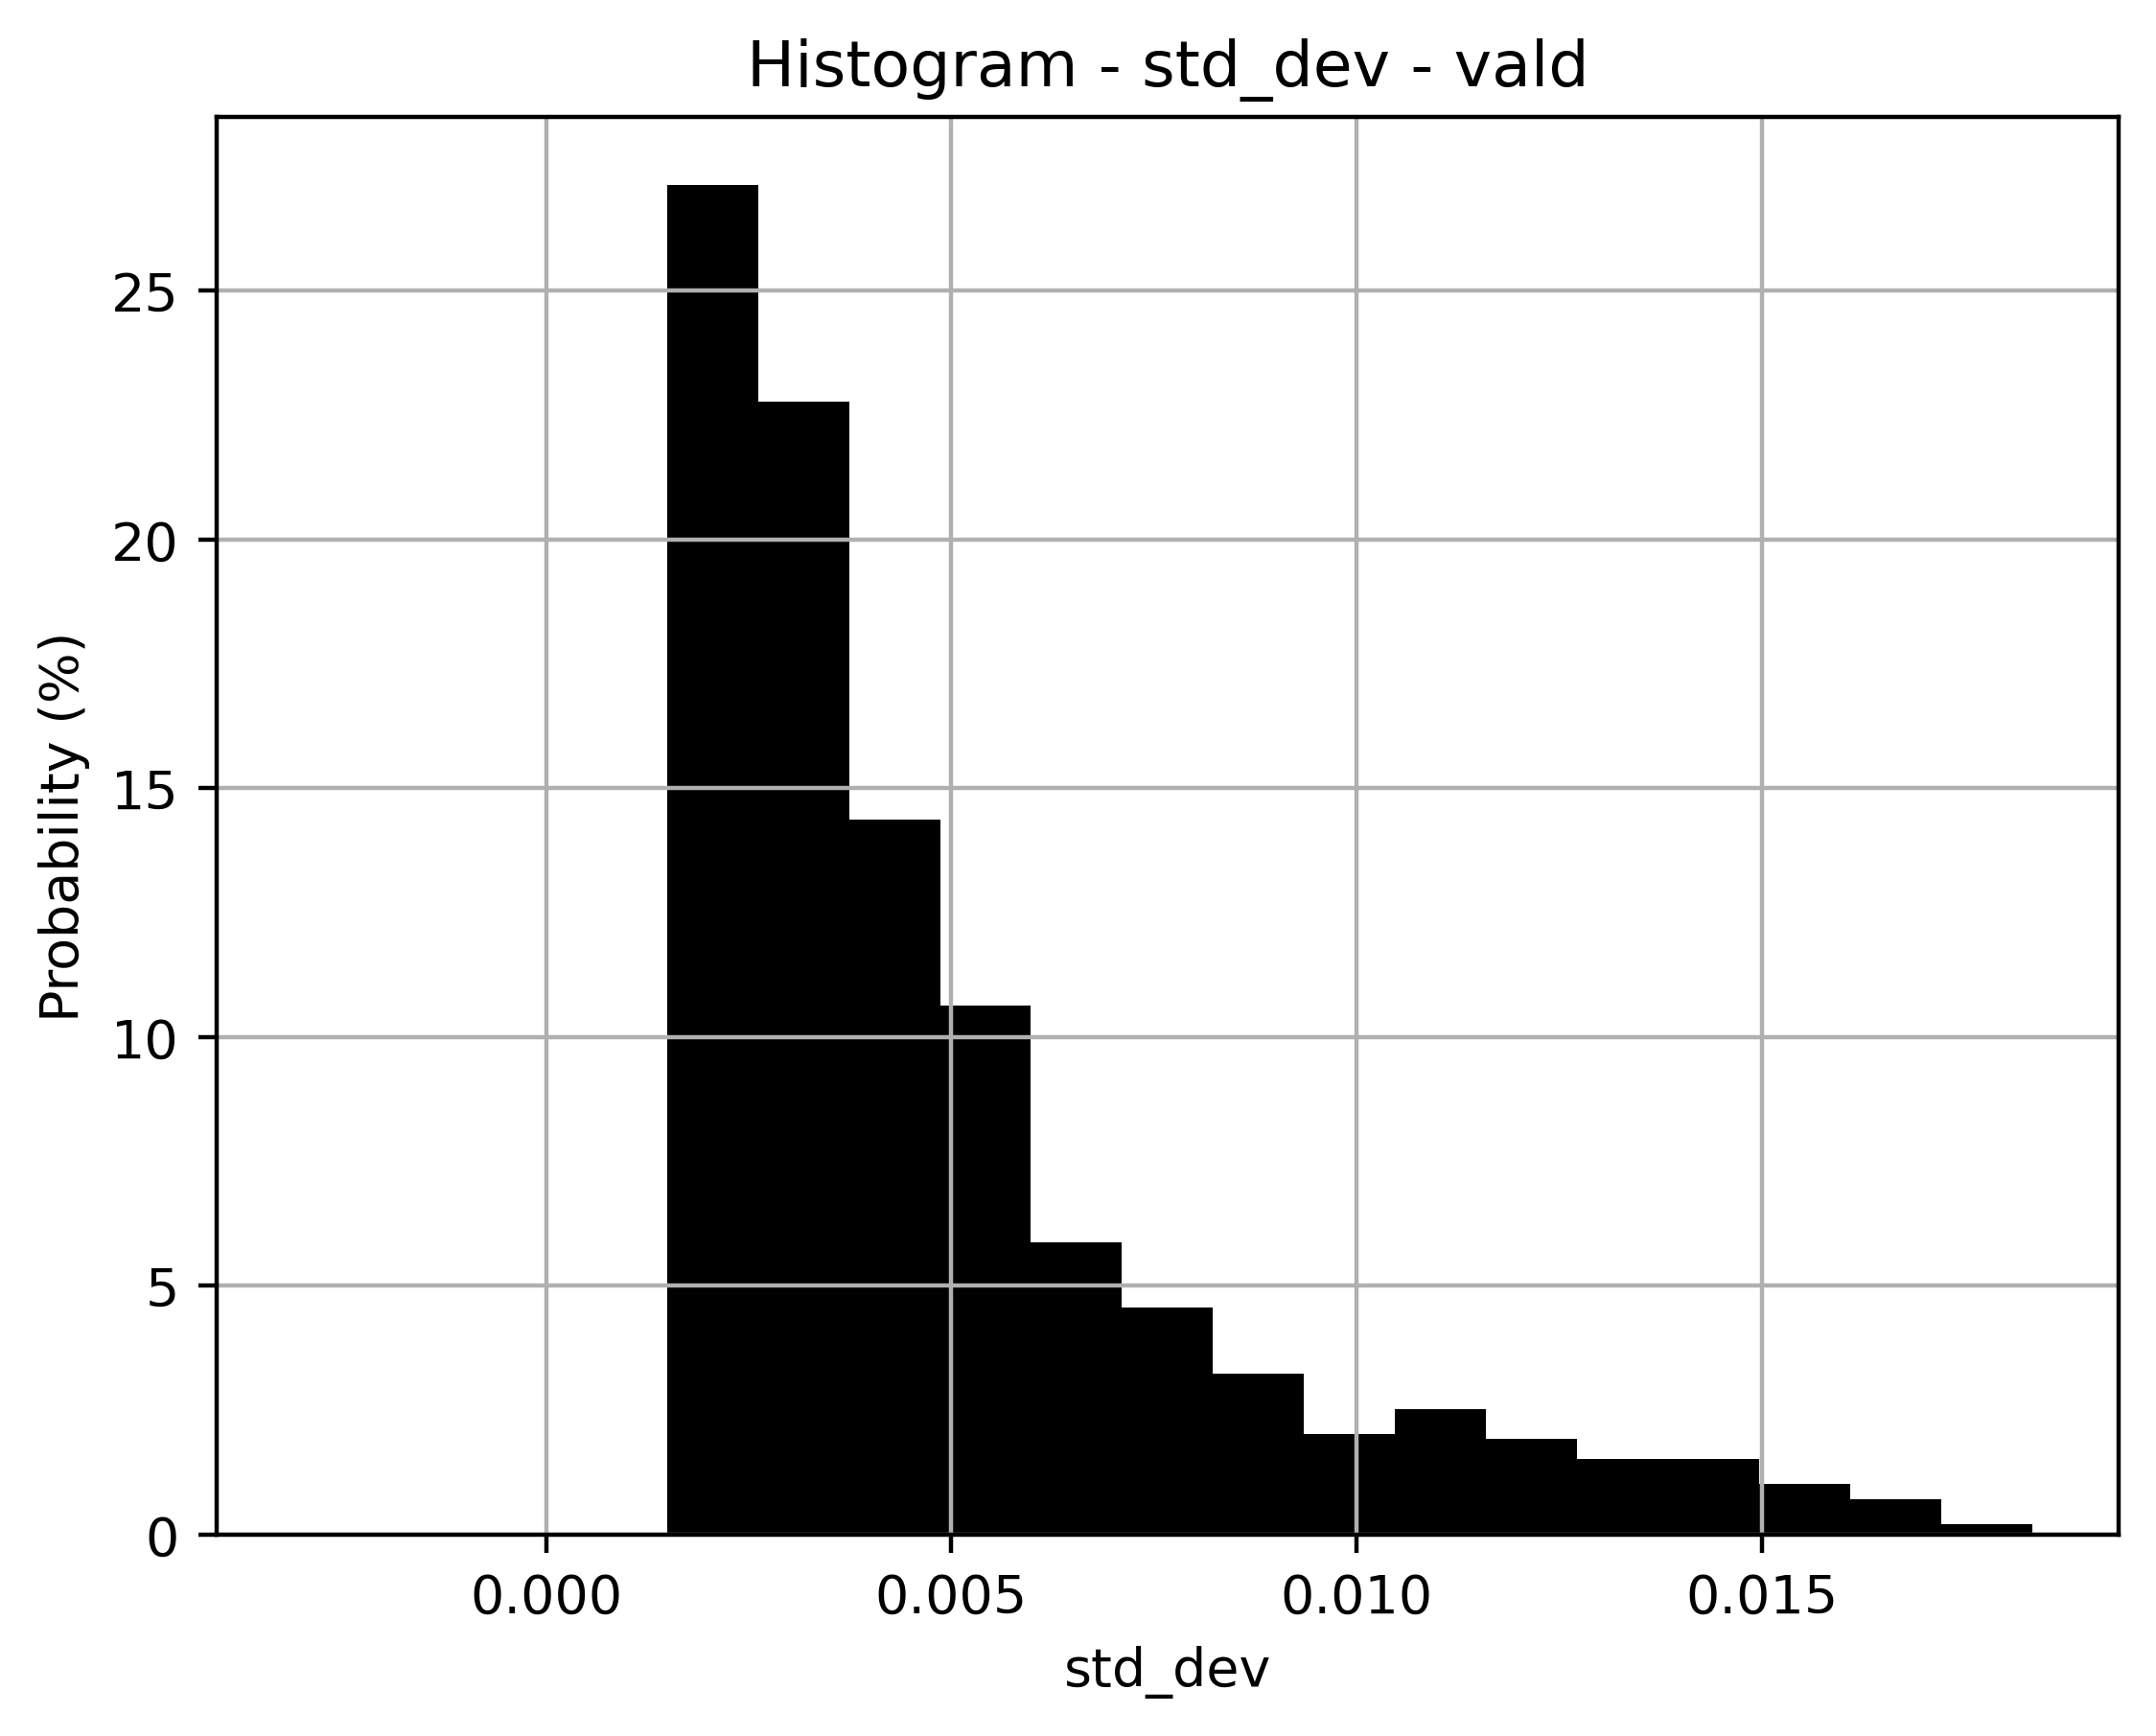

In [10]:
bins = np.linspace((1/500)-0.005,(1/75)+0.005,20)
plot_hist(std_dev_train,bins,plot_title = 'Histogram - std_dev - train',xaxis_title='std_dev')
bins = np.linspace((1/500)-0.005,(1/75)+0.005,20)
plot_hist(std_dev_vald,bins,plot_title = 'Histogram - std_dev - vald',xaxis_title='std_dev')

In [11]:
train_lc_scaled_append_noise = np.ones(train_lc_scaled_append.shape)
vald_lc_scaled_append_noise = np.ones(vald_lc_scaled_append.shape)

for i in np.arange(len(train_lc_scaled_append)):
    train_lc_scaled_append_noise[i] = train_lc_scaled_append[i] + np.random.normal(loc=0.0, scale=std_dev_train[i], size=len(train_lc_scaled_append[i]))

for i in np.arange(len(vald_lc_scaled_append)):
    vald_lc_scaled_append_noise[i] = vald_lc_scaled_append[i] + np.random.normal(loc=0.0, scale=std_dev_vald[i], size=len(vald_lc_scaled_append[i]))

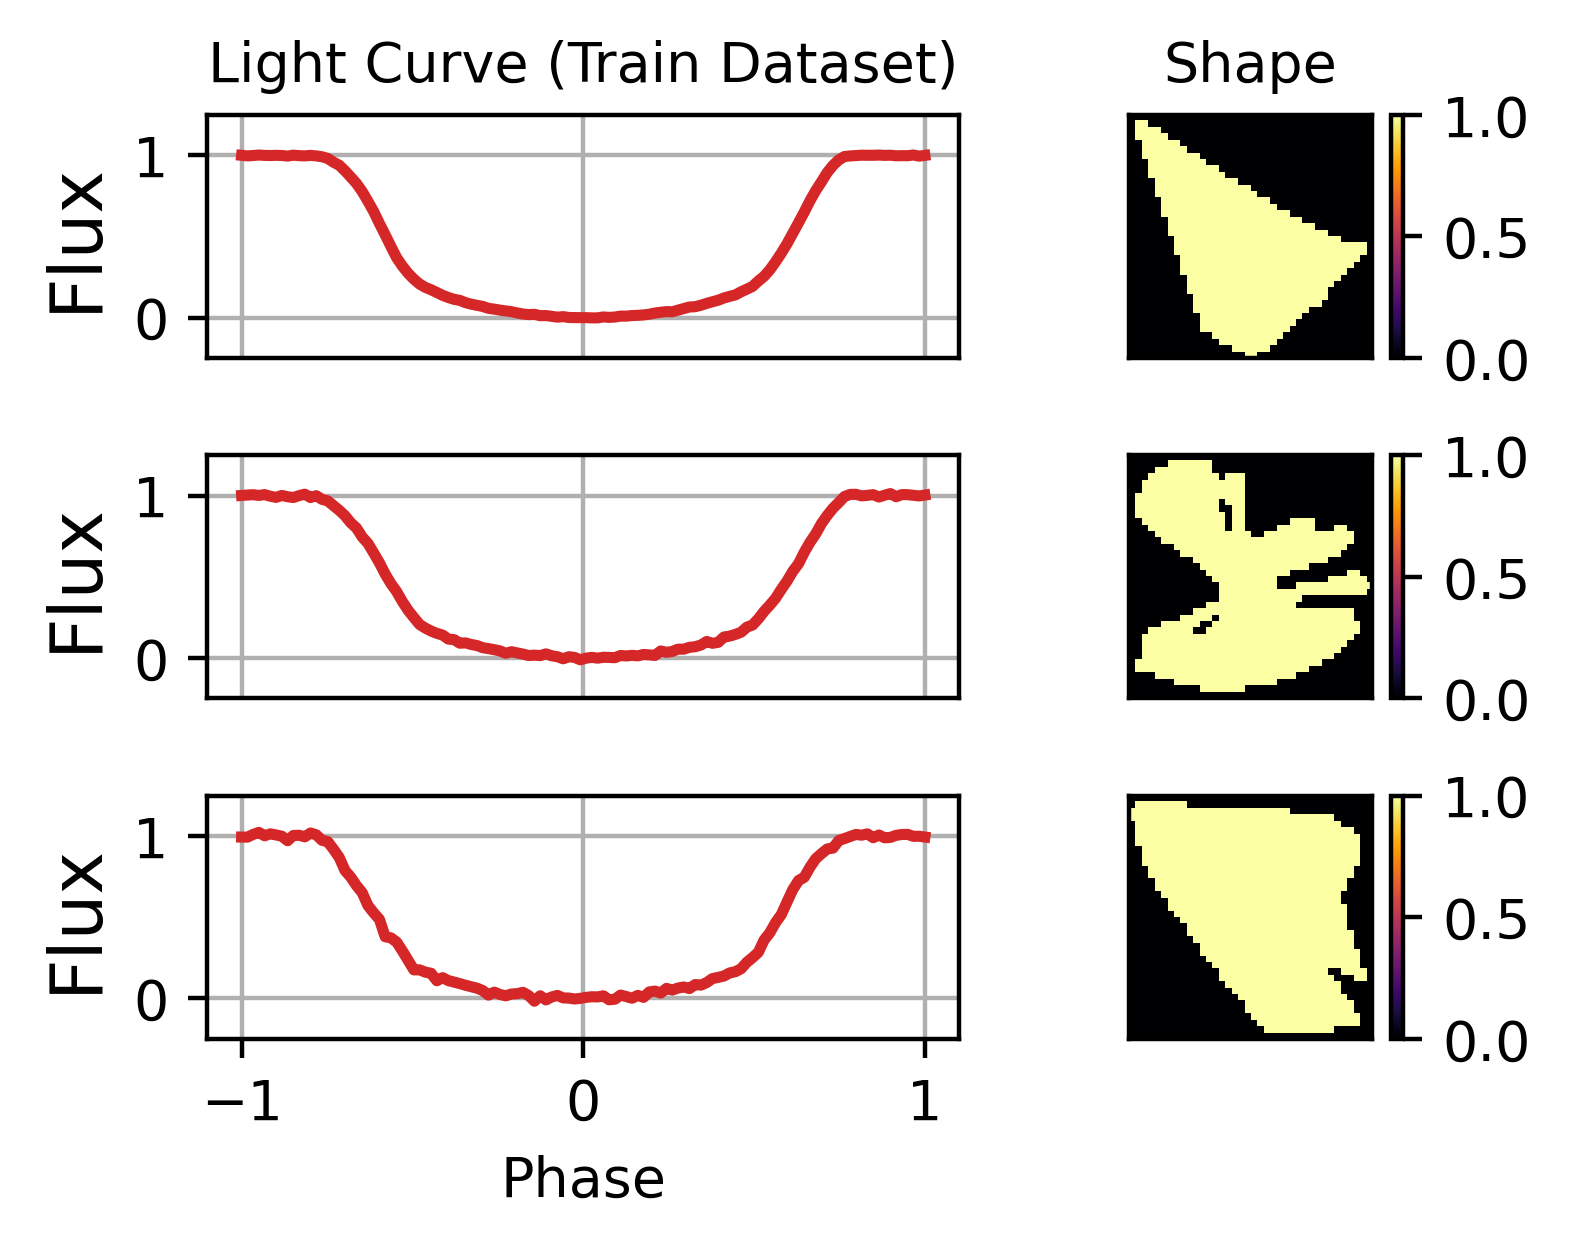

In [12]:
# Verification
# Plot - Train LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400

ax[0][1].set_title('Shape',size=10)
ax[0][0].set_title('Light Curve (Train Dataset)',size=10)
ax[num-1][0].set_xlabel('Phase',size=10)
ph = np.linspace(-1,1,len(train_lc_scaled_append_noise[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(train_lc_scaled_append_noise)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    # ax[i][0].set_ylim(-3*(1/SNR),3*(1/SNR))
    ax[i][0].set_ylim(-0.25,1.25)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, train_lc_scaled_append_noise[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

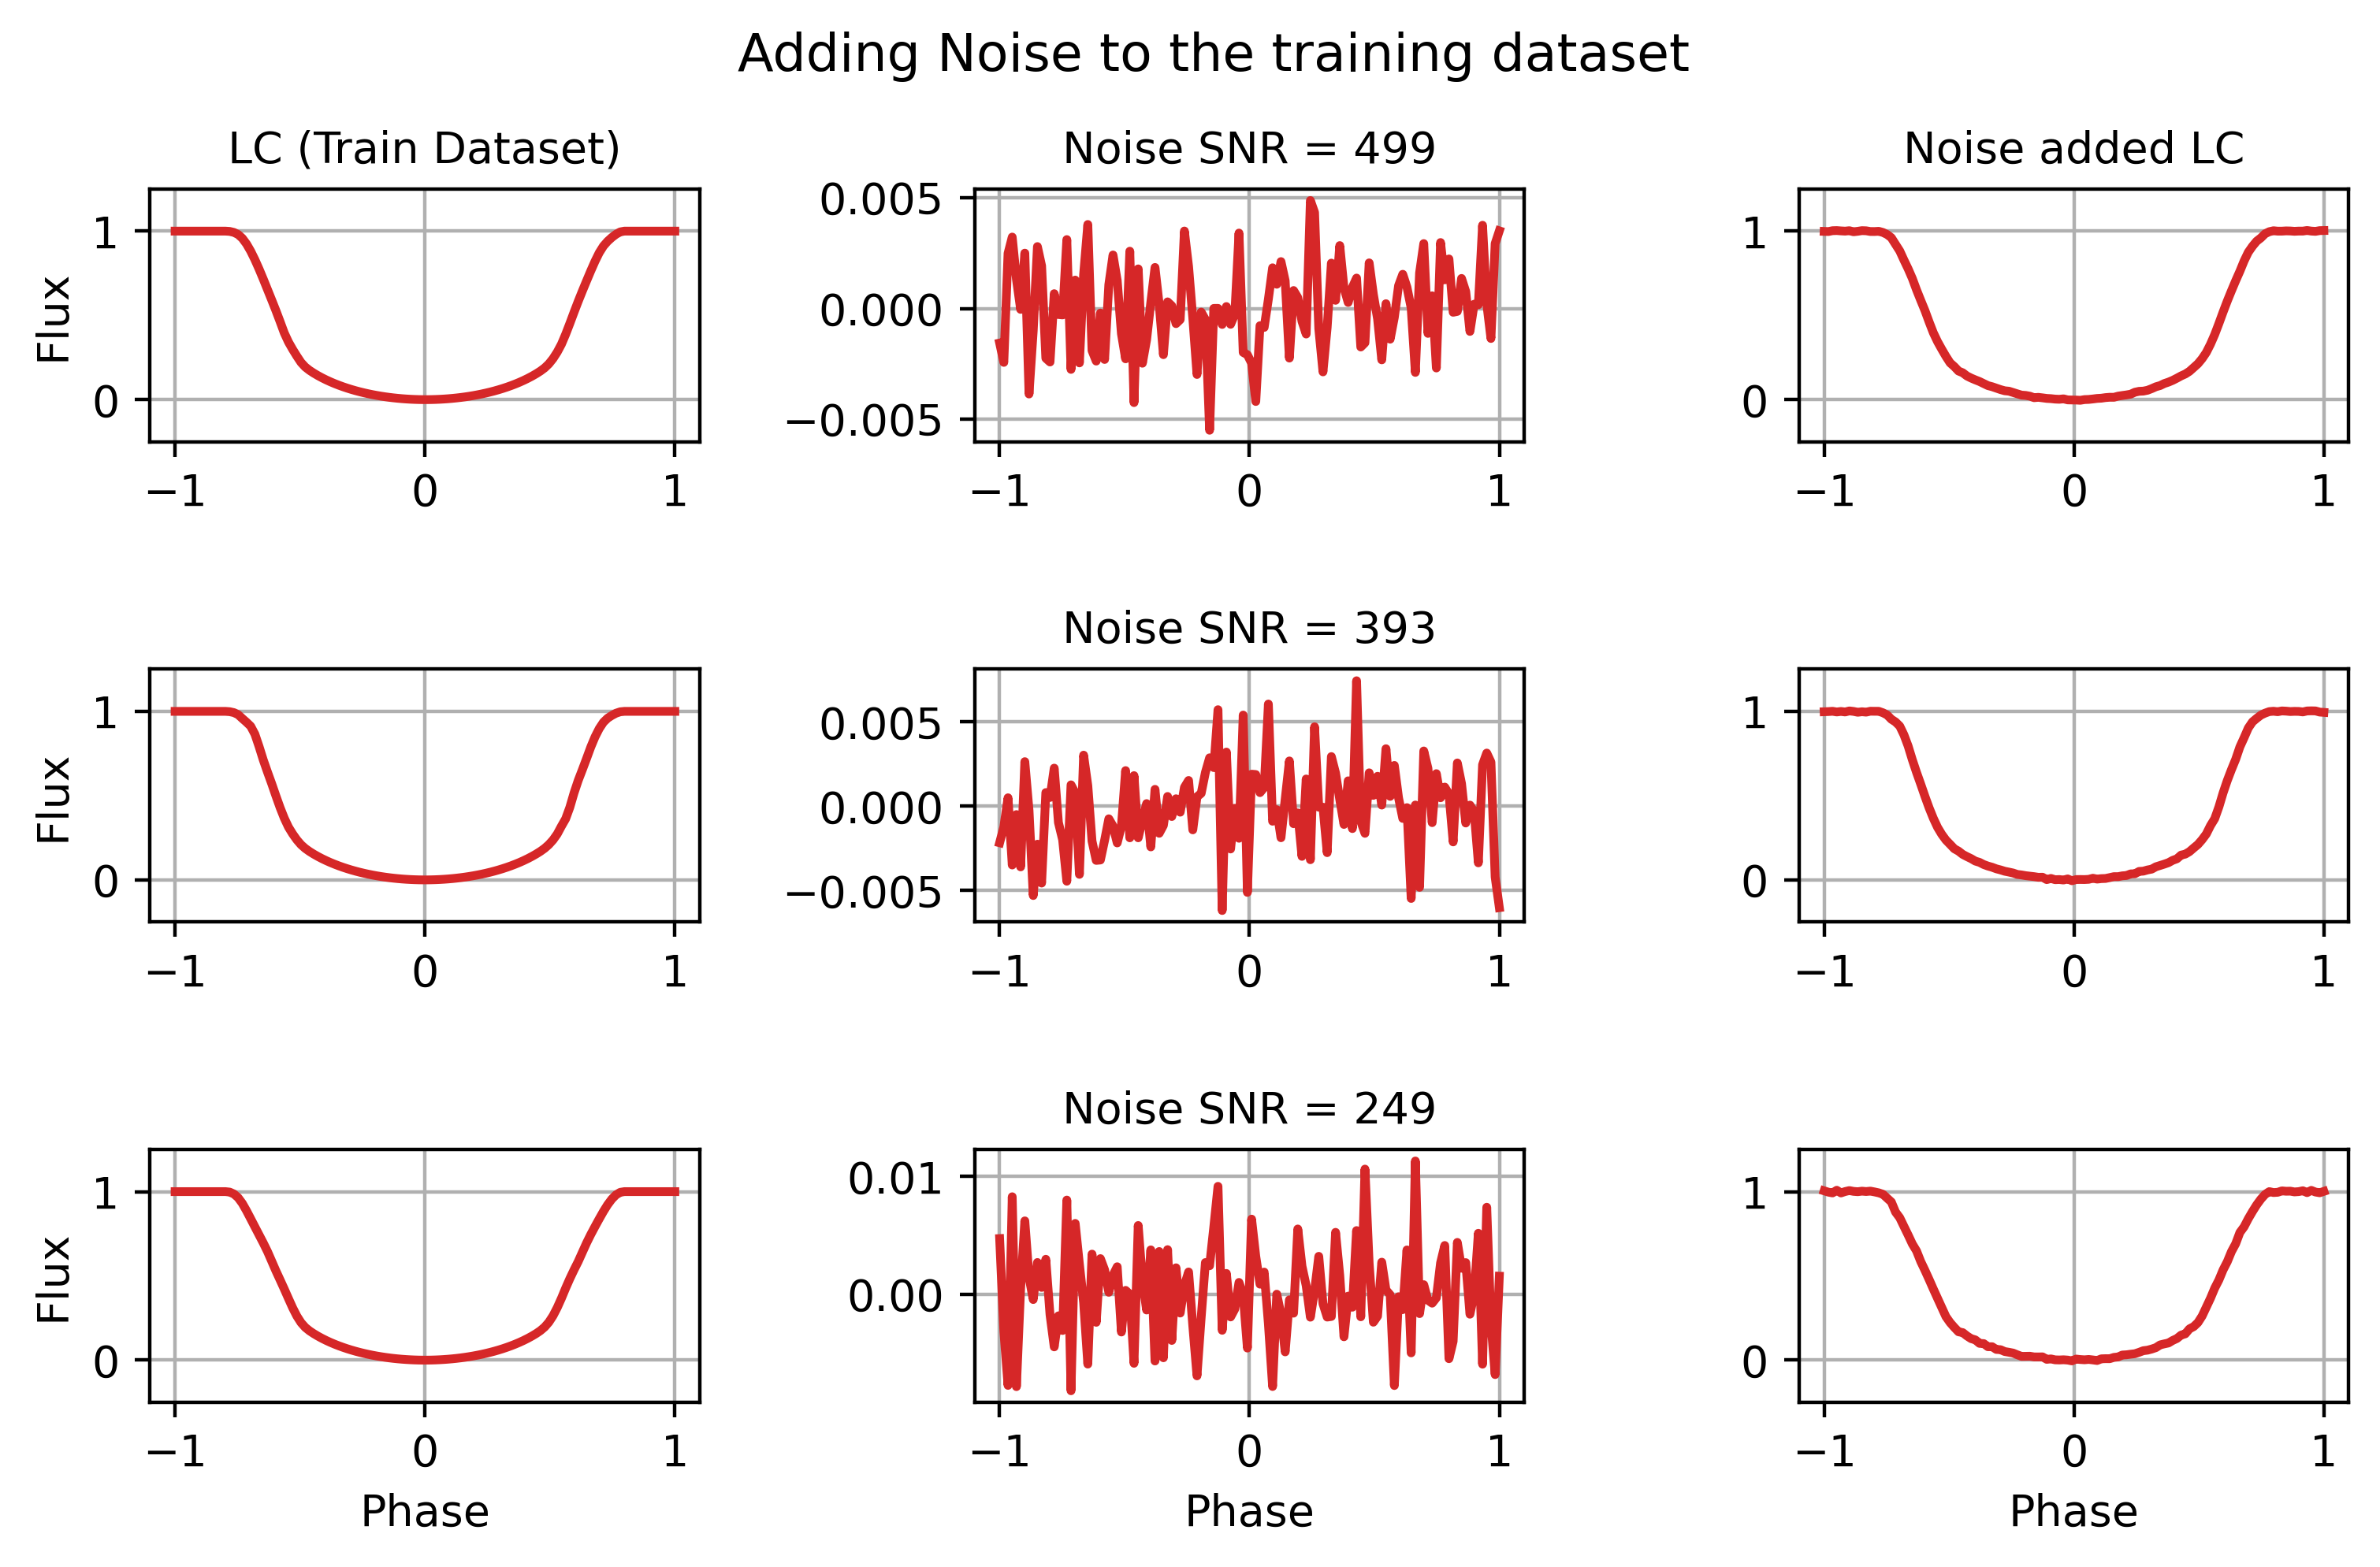

In [13]:
# Verification
# Plot - Train LCs
num = 3
fig,ax=plt.subplots(num,3, figsize=(9,5), gridspec_kw={ 'width_ratios': [2,2,2],
        'wspace': 0.5,'hspace': 0.9})
plt.rcParams['figure.dpi'] = 400

ax[0][2].set_title('Noise added LC',size=10)
# ax[0][1].set_title('Noise',size=10)
ax[0][0].set_title('LC (Train Dataset)',size=10)
ax[num-1][0].set_xlabel('Phase',size=10)
ax[num-1][1].set_xlabel('Phase',size=10)
ax[num-1][2].set_xlabel('Phase',size=10)

ph = np.linspace(-1,1,len(train_lc_scaled_append_noise[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(train_lc_scaled_append_noise)-1)
    ax[i][0].set_ylabel('Flux',size=10)
    ax[i][0].set_ylim(-0.25,1.25)
    ax[i][0].plot(ph, train_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')

    # ax[i][1].set_ylim(-3*(1/SNR),3*(1/SNR))
    ax[i][1].plot(ph, train_lc_scaled_append_noise[k]-train_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][1].grid('on')
    ax[i][1].set_title(f'Noise SNR = {int(np.around(1/np.std(train_lc_scaled_append_noise[k]-train_lc_scaled_append[k]),0))}',size=10)
    # ax[i][1].set_ylabel('Flux',size=13)


    # ax[i][2].set_ylabel('Flux',size=13)
    ax[i][2].set_ylim(-0.25,1.25)
    ax[i][2].plot(ph, train_lc_scaled_append_noise[k],color = 'tab:red',linewidth='2')
    ax[i][2].grid('on')


    i = i + 1
plt.suptitle(f"Adding Noise to the training dataset")
plt.show()

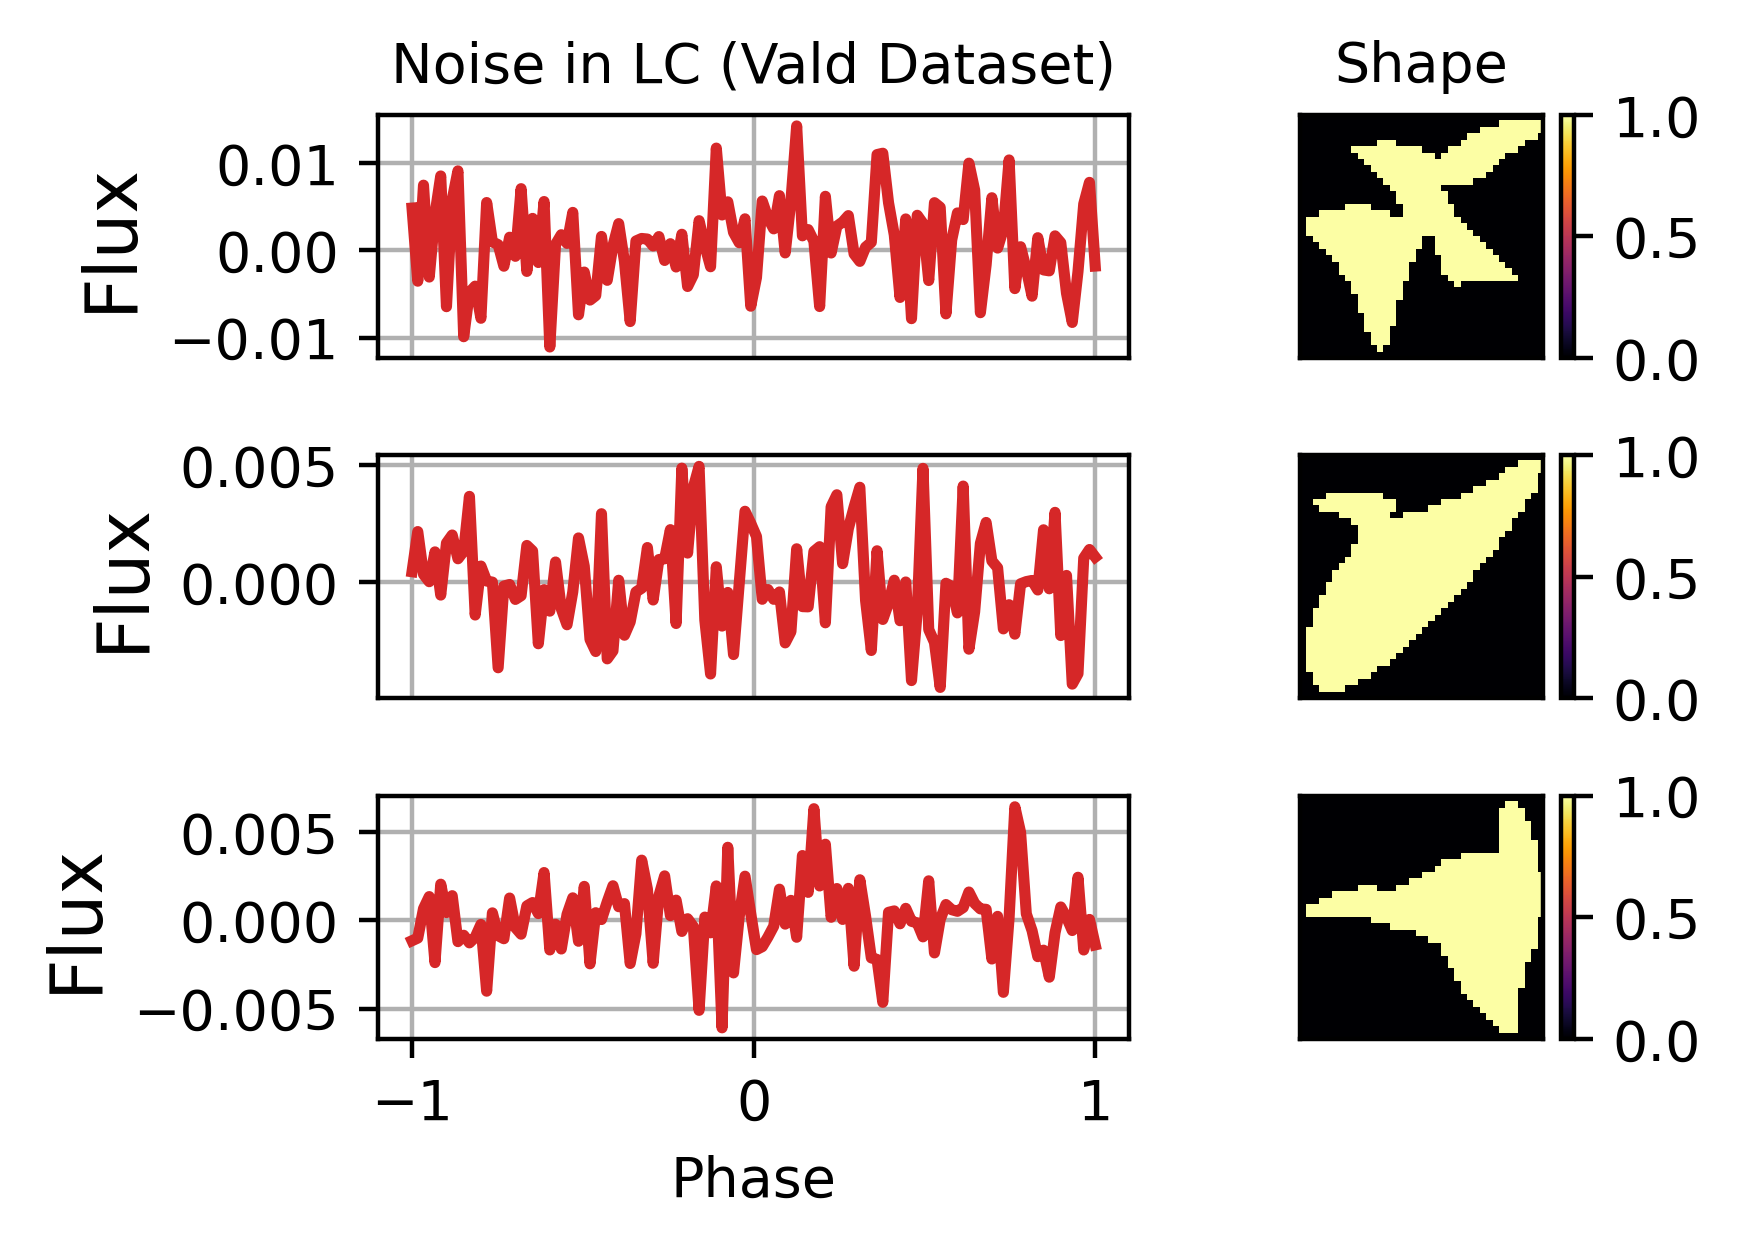

In [14]:
# Verification
# Plot - vald LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400

ax[0][1].set_title('Shape',size=10)
ax[0][0].set_title('Noise in LC (Vald Dataset)',size=10)
ax[num-1][0].set_xlabel('Phase',size=10)
ph = np.linspace(-1,1,len(vald_lc_scaled_append_noise[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(vald_lc_scaled_append_noise)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(vald_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    # ax[i][0].set_ylim(-3*(1/SNR),3*(1/SNR))
    # ax[i][0].set_ylim(-0.5,1.5)
#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph,vald_lc_scaled_append_noise[k]-vald_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

## ML Training


In [15]:
# ML Pipeline
## Train Set
# train_dataset = tf.data.Dataset.from_tensor_slices((concat_train_lc,concat_train_shape))
train_dataset = tf.data.Dataset.from_tensor_slices((train_lc_scaled_append_noise,train_shape))
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(len(train_dataset))
train_dataset = train_dataset.batch(100)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
print(train_dataset)

## Vald Set
# vald_dataset = tf.data.Dataset.from_tensor_slices((concat_vald_lc,concat_vald_shape))
vald_dataset = tf.data.Dataset.from_tensor_slices((vald_lc_scaled_append_noise,vald_shape))
vald_dataset = vald_dataset.batch(100)
vald_dataset = vald_dataset.cache()
vald_dataset = vald_dataset.prefetch(tf.data.AUTOTUNE)

print(vald_dataset)

2023-11-10 12:22:44.348160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30937 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120), dtype=tf.float64, name=None), TensorSpec(shape=(None, 38, 38), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120), dtype=tf.float64, name=None), TensorSpec(shape=(None, 38, 38), dtype=tf.float64, name=None))>


In [16]:
# CNN Model
input_shape = np.array(np.shape(train_lc_scaled_append_noise[0]))
print("np.shape(input_shape) = ",input_shape[0])

output_shape = np.array(np.shape(train_shape[0]))
print("np.shape(input_shape) = ",output_shape[0],output_shape[1])

START = input_shape[0] # 94 #
END = output_shape[0] # 38  # pixel size along one axis
print("Start = ",START)
print("End = ",END)

conv_ip = keras.layers.Input(shape=(START,),name='Input')
x= keras.layers.Reshape((START, 1), input_shape=(START,),name='reshape_1')(conv_ip)
x= keras.layers.BatchNormalization()(x)

x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='conv16_5', padding='same')(x)
x=keras.layers.Conv1D(16,kernel_size=5,strides=1,activation='relu',name='second_conv16_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_1', padding='same')(x) #400

x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='first_conv32_5', padding='same')(x)
x=keras.layers.Conv1D(32,kernel_size=5,strides=1,activation='relu',name='second_conv32_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_2', padding='same')(x) #200

x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='first_conv64_5', padding='same')(x)
x=keras.layers.Conv1D(64,kernel_size=5,strides=1,activation='relu',name='second_conv64_5', padding='same')(x)
x=keras.layers.MaxPool1D(5,strides=2,data_format='channels_last',name='maxpool_3', padding='same')(x) #100

x=keras.layers.Flatten(name='flat_1')(x)

x2=keras.layers.Dense(256,name='dense_layer_5',activation='relu')(x)
x2=keras.layers.Dense(256,name='dense_layer_6',activation='relu')(x2)

x2= keras.layers.Dense(END**2,name='dense_layer_u',activation='relu')(x2)
x2 = keras.layers.Reshape(target_shape=(END, END, 1),name='reshape_2')(x2)

x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_52', padding='same')(x2)
x2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_522', padding='same')(x2)
x2=keras.layers.Conv2D(16,kernel_size=(3,3),strides=1,activation='relu',name='second_conv64_524', padding='same')(x2)
x2=keras.layers.Conv2D(1,kernel_size=3,strides=1,activation='relu',name='second_conv64_53', padding='same')(x2)
conv_op = keras.layers.Reshape(target_shape=(END, END),name='reshape_3')(x2)
model = keras.Model(inputs=conv_ip, outputs=conv_op, name="predict_shape_from_LC")
model.summary()
print("Model is defined")

np.shape(input_shape) =  120
np.shape(input_shape) =  38 38
Start =  120
End =  38
Model: "predict_shape_from_LC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 120)]             0         
                                                                 
 reshape_1 (Reshape)         (None, 120, 1)            0         
                                                                 
 batch_normalization (BatchN  (None, 120, 1)           4         
 ormalization)                                                   
                                                                 
 conv16_5 (Conv1D)           (None, 120, 16)           96        
                                                                 
 second_conv16_5 (Conv1D)    (None, 120, 16)           1296      
                                                                 
 maxpool_1 (MaxPooling1D)   

In [17]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
print("Model is compiled")

#Patience early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
print("Early stopping defined")

#Learning rate scheduler
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 20
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate
lr_sched = keras.callbacks.LearningRateScheduler(step_decay)
print("Learning rate scheduler defined")

Model is compiled
Early stopping defined
Learning rate scheduler defined


In [18]:
# Training 
print("Training will start now")
# history = model.fit(train_lc_scaled, train_shape, epochs=2000,verbose=2, validation_data=(vald_lc_scaled,vald_shape),callbacks=[es,lr_sched])
history = model.fit(train_dataset, epochs=200,verbose=2, validation_data=vald_dataset,callbacks=[es,lr_sched])
# history = model.fit(train_lc_scaled_append_noise,train_shape, epochs=2000,verbose=2, validation_data=(vald_lc_scaled_append_noise,vald_shape),callbacks=[es,lr_sched])

# Save Model (Uncomment onlt if you are really running this)
# save_model(model, "ml_saved_models/model_sep22_unf_ 0_500_v1/model_sep22_unf_50_500_v1.h5")

Training will start now


2023-09-22 13:02:01.150268: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 126850560 exceeds 10% of free system memory.
2023-09-22 13:02:02.697899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [132136,120]
	 [[{{node Placeholder/_0}}]]
2023-09-22 13:02:02.698336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [132136,38,38]
	 [[{{node Placeholder/_1}}]]


Epoch 1/200


2023-09-22 13:02:07.575300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-22 13:02:11.150091: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f4a50fde8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-22 13:02:11.150146: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-09-22 13:02:11.156831: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-22 13:02:12.322006: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-09-22 13:02:49.353688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can i

1322/1322 - 47s - loss: 0.1521 - val_loss: 0.1366 - lr: 0.0010 - 47s/epoch - 35ms/step
Epoch 2/200
1322/1322 - 25s - loss: 0.1342 - val_loss: 0.1353 - lr: 0.0010 - 25s/epoch - 19ms/step
Epoch 3/200
1322/1322 - 25s - loss: 0.1298 - val_loss: 0.1277 - lr: 0.0010 - 25s/epoch - 19ms/step
Epoch 4/200
1322/1322 - 25s - loss: 0.1276 - val_loss: 0.1244 - lr: 0.0010 - 25s/epoch - 19ms/step
Epoch 5/200
1322/1322 - 25s - loss: 0.1261 - val_loss: 0.1245 - lr: 0.0010 - 25s/epoch - 19ms/step
Epoch 6/200
1322/1322 - 24s - loss: 0.1254 - val_loss: 0.1261 - lr: 0.0010 - 24s/epoch - 18ms/step
Epoch 7/200
1322/1322 - 24s - loss: 0.1249 - val_loss: 0.1238 - lr: 0.0010 - 24s/epoch - 18ms/step
Epoch 8/200
1322/1322 - 24s - loss: 0.1245 - val_loss: 0.1268 - lr: 0.0010 - 24s/epoch - 18ms/step
Epoch 9/200
1322/1322 - 24s - loss: 0.1242 - val_loss: 0.1239 - lr: 0.0010 - 24s/epoch - 18ms/step
Epoch 10/200
1322/1322 - 25s - loss: 0.1239 - val_loss: 0.1220 - lr: 0.0010 - 25s/epoch - 19ms/step
Epoch 11/200
1322/132

test Set: No. of LC = No. of shapes
Extended the light curves


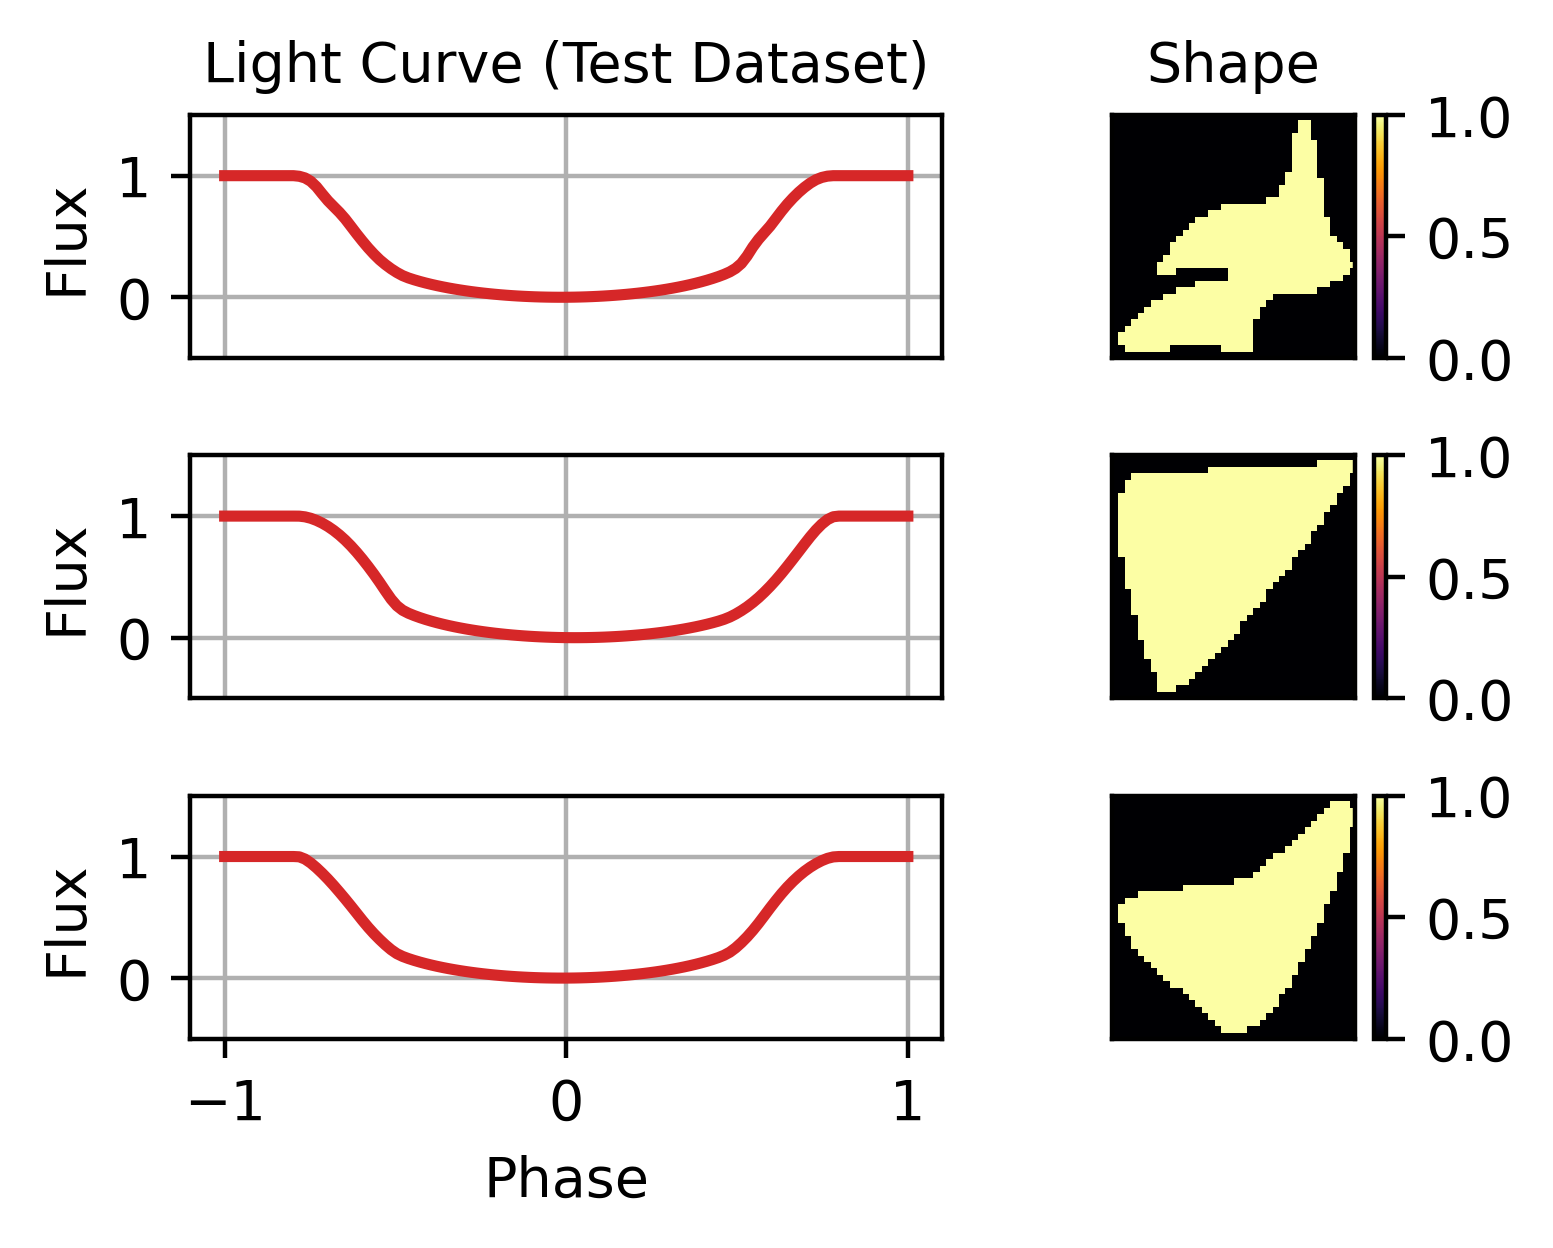

In [19]:
# Load Test Dataset
test_shape_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/shape_npy/shape_filled8.npy'
test_lc_dir = '/home/abraham/Documents/ms_proj_shape_lc_gen/data_npy/lc_npy/lc_dict_8.npy'
test_lc = np.load(test_lc_dir)
test_shape = np.load(test_shape_dir)
# Check equality of number of dataset
if len(test_lc)==len(test_shape):
    print("test Set: No. of LC = No. of shapes")
else:
    sys.exit("EXIT: testn Set: No. of LC != No. of shapes")

# Normalize the image, convert to opacity map
## Test Set
test_shape = test_shape/np.amax(test_shape)
test_shape_where_0 = np.where(test_shape == 0)
test_shape_where_1 = np.where(test_shape == 1)
test_shape[test_shape_where_0] = 1  # 1 represent the shape (1 opacity)
test_shape[test_shape_where_1] = 0  # 0 represent background (0 opacity)


# Normalize the lightcurves
## - Test Set
test_lc_scaled = np.zeros(test_lc.shape)
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled[i] = (test_lc[i] - np.amin(test_lc[i]))/(np.amax(test_lc[i]) - np.amin(test_lc[i]))

# Append with ones
## - Test Set
test_lc_scaled_append = np.ones((test_lc.shape[0],120))
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled_append[i,10:110] = test_lc_scaled[i]
print("Extended the light curves")

# Verification
# Plot - Test LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400

ax[0][1].set_title('Shape',size=10)
ax[0][0].set_title('Light Curve (Test Dataset)',size=10)
ax[num-1][0].set_xlabel('Phase',size=10)
ph = np.linspace(-1,1,len(test_lc_scaled_append[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(test_lc_scaled_append)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=10)
    ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].plot(ph,test_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1


In [20]:
# Add noise to Test light curve
random_generator = np.random.default_rng()
SNR_array_test = random_generator.uniform(50,500,len(test_lc_scaled_append))
std_dev_test = 1/SNR_array_test
del SNR_array_test

test_lc_scaled_append_noise = np.ones(test_lc_scaled_append.shape)

for i in np.arange(len(test_lc_scaled_append)):
    if int(i) % 2 == 0:
        noise_temp = np.random.normal(loc=0.0, scale=std_dev_test[i], size=len(test_lc_scaled_append[i]))
        random_generator.shuffle(noise_temp)
    else:
        noise_temp = np.random.normal(loc=0.0, scale=std_dev_test[i], size=len(test_lc_scaled_append[i]))
    test_lc_scaled_append_noise[i] = test_lc_scaled_append[i] + noise_temp


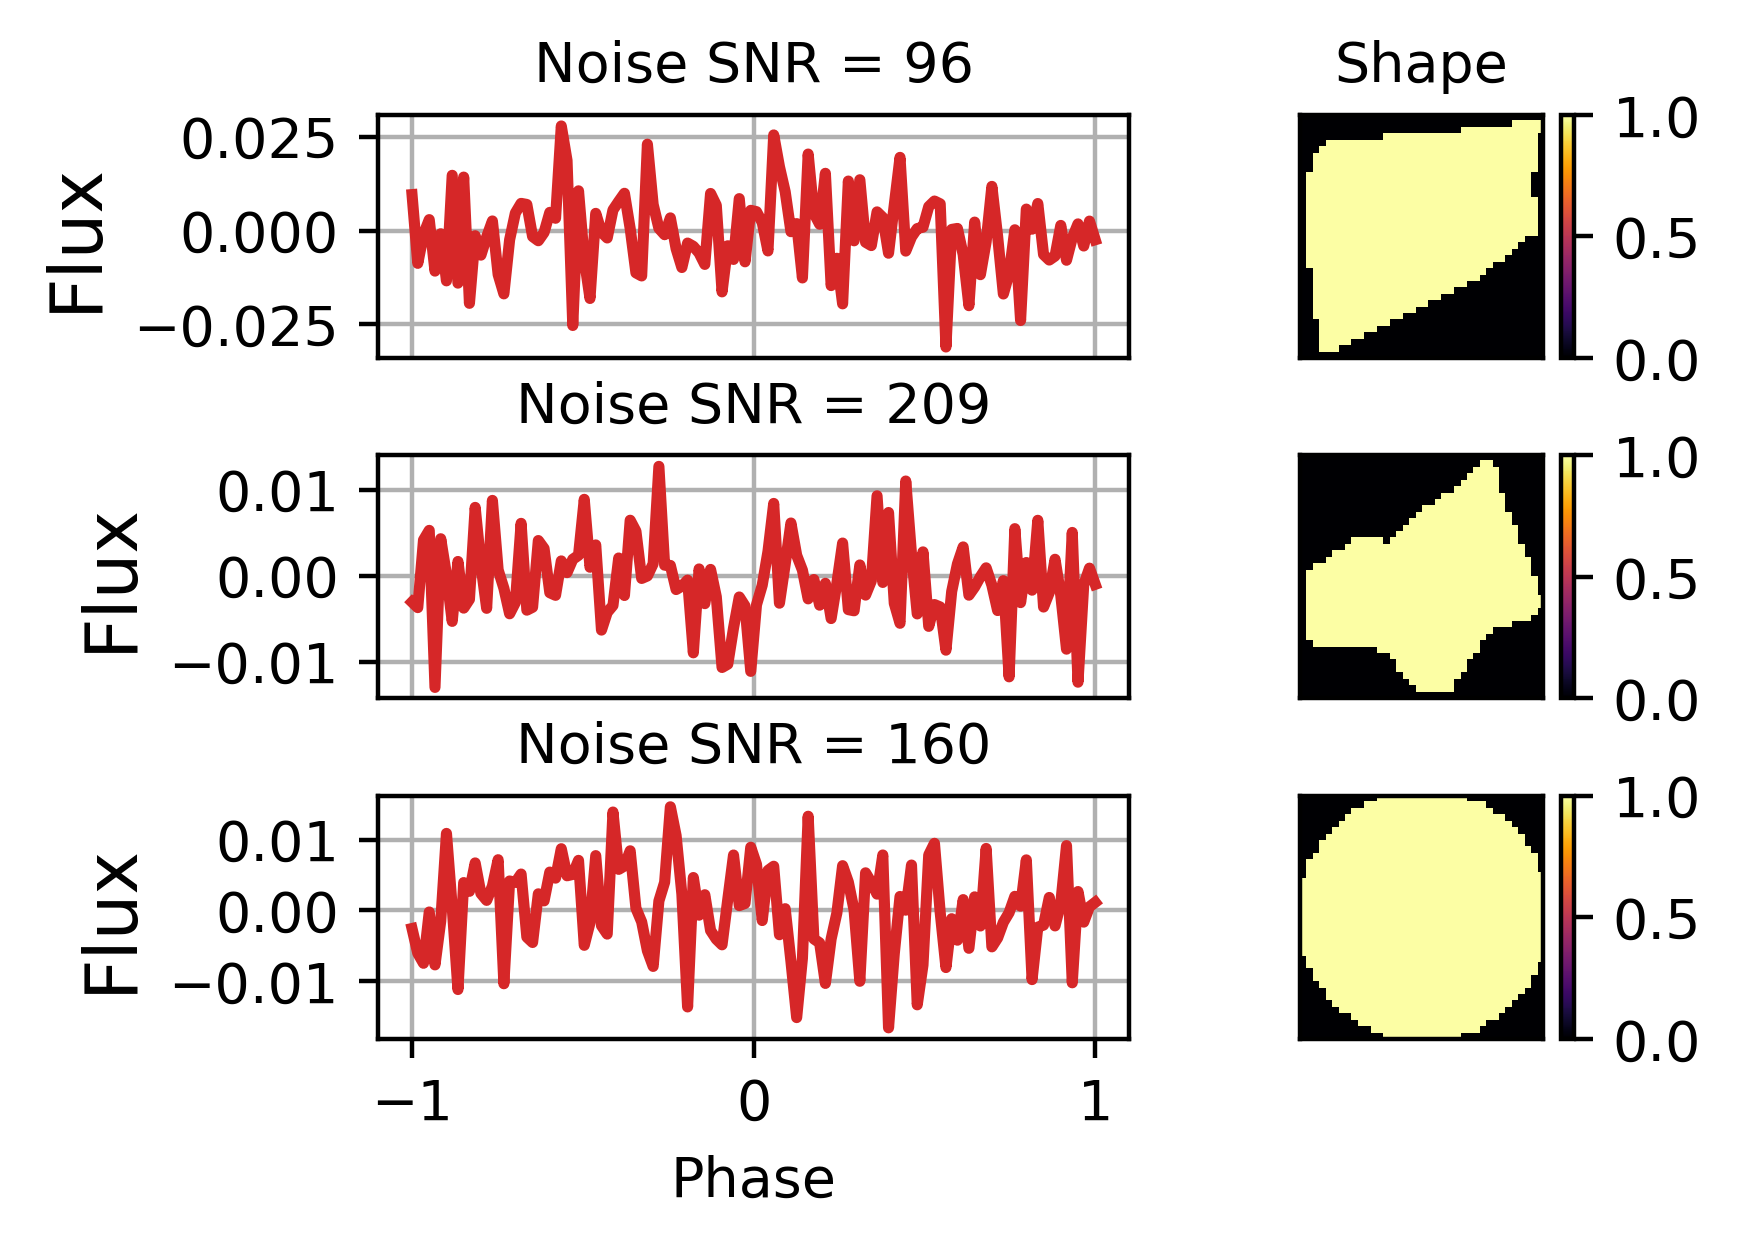

In [21]:
# Verification
# Plot - Test LCs
num = 3
fig,ax=plt.subplots(num,2, figsize=(4,3), gridspec_kw={ 'width_ratios': [2,1],
        'wspace': 0.2,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400

ax[0][1].set_title('Shape',size=10)
# ax[0][0].set_title('Light Curve (Test Dataset)',size=10)
ax[num-1][0].set_xlabel('Phase',size=10)
ph = np.linspace(-1,1,len(test_lc_scaled_append_noise[0]))
# advance = 60

i = 0
for i in np.arange(0,num):
    k = random.randint(0, len(test_lc_scaled_append_noise)-1)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(train_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=13)
    # ax[i][0].set_ylim(-3*(1/SNR),3*(1/SNR))
    ax[i][0].set_title(f'Noise SNR = {int(np.around(1/np.std(test_lc_scaled_append_noise[k]-test_lc_scaled_append[k]),0))}',size=10)

#     ax[i][0].scatter(ph, vald_lc_scaled_append[k],color = 'black',marker='.')
    ax[i][0].plot(ph, test_lc_scaled_append_noise[k]-test_lc_scaled_append[k],color = 'tab:red',linewidth='2')
    ax[i][0].grid('on')
    i = i + 1

In [22]:
model_load = load_model("ml_saved_models/model_sep22_unf_50_500_v1/model_sep22_unf_50_500_v1.h5")
results = model_load.evaluate(test_lc_scaled_append_noise, test_shape, batch_size=128)
results

2/2 [==============================] - 1s 211ms/step - loss: 0.1201


0.12005369365215302

In [23]:
# Test on the ML model - Test Dataset
# Test dataset - Prediciton
test_predict_shape = model_load.predict(test_lc_scaled_append_noise)
test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
for i in np.arange(len(test_predict_shape)):
    test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
print("Normalized the predicted shape")
test_predict_shape = test_predict_shape_normalized
del test_predict_shape_normalized

8/8 [==============================] - 1s 28ms/step
Normalized the predicted shape


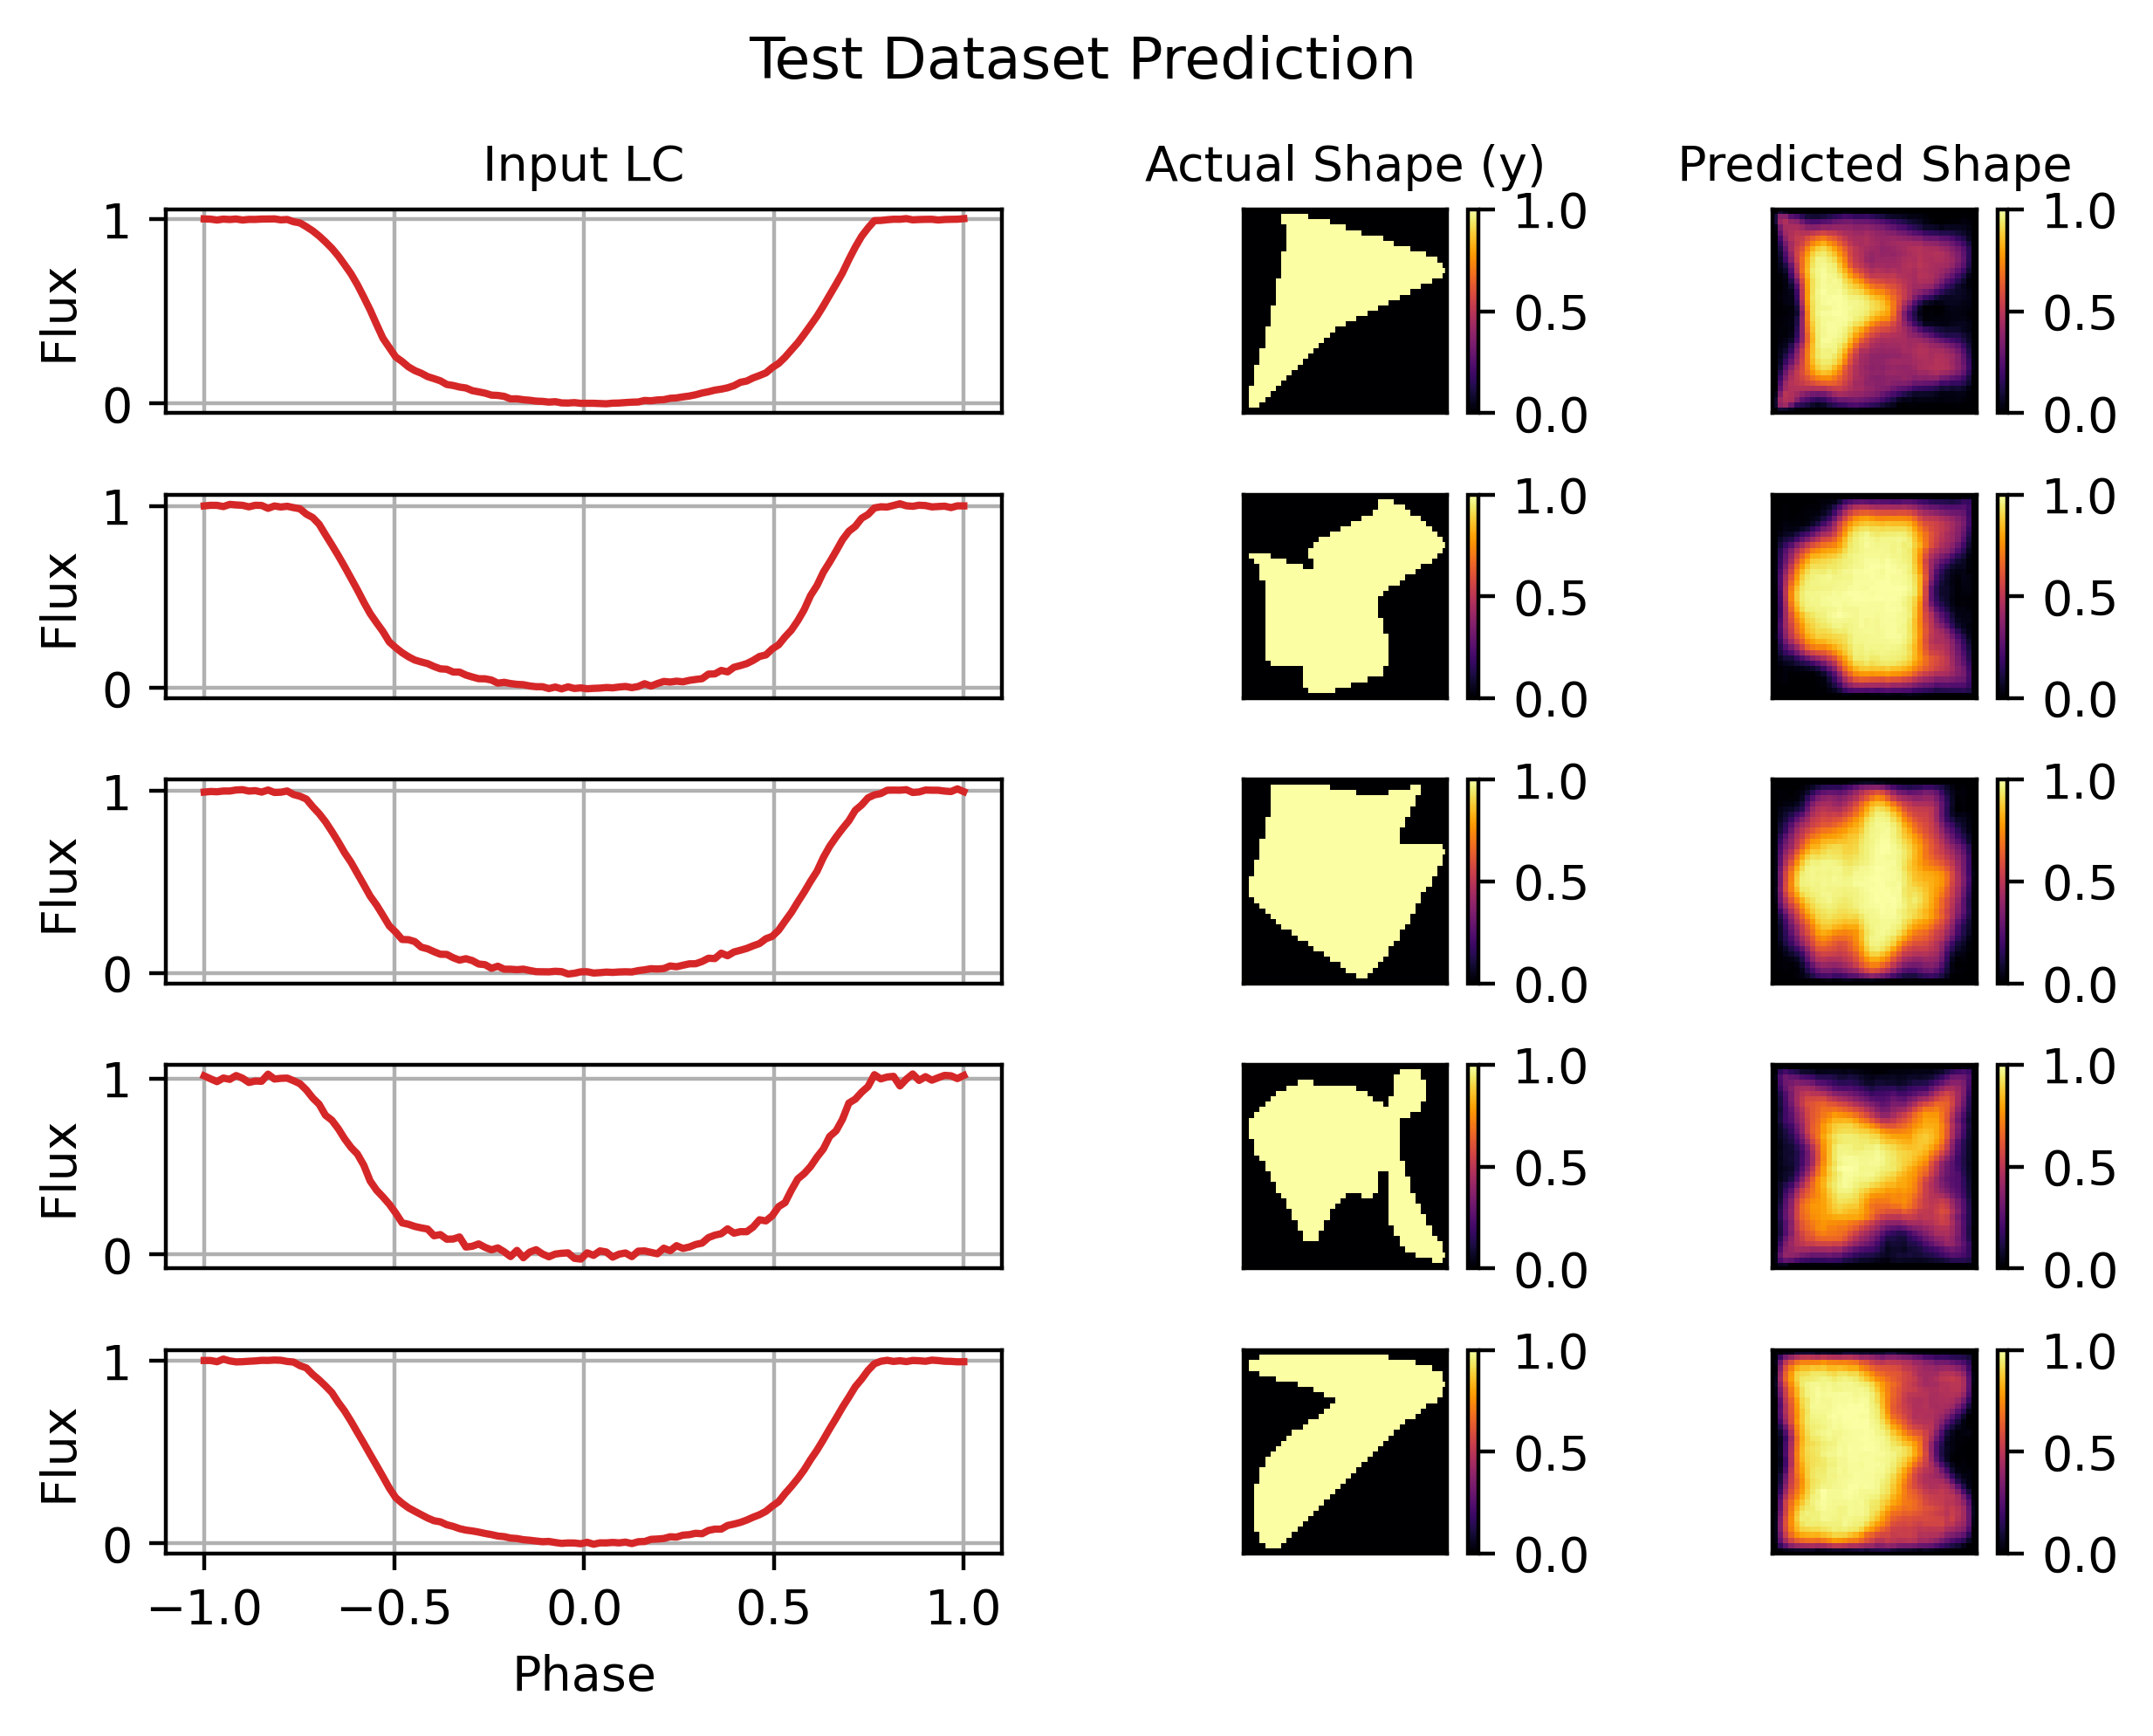

In [25]:

num = 5
fig,ax=plt.subplots(num,3, figsize=(7,5), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 400

ax[0][0].set_title('Input LC',size=10)
ax[0][1].set_title('Actual Shape (y)',size=10)
ax[0][2].set_title(r'Predicted Shape',size=10)
ax[num-1][0].set_xlabel('Phase',size=10)
ph = np.linspace(-1.0,1.0,len(test_lc_scaled_append_noise[0]))
# advance = 60
for i in range(num):
    k =  random.randint(0, len(test_lc_scaled_append_noise)-1) # 249 - i #
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_ylabel('Flux',size=10)
    # ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].plot(ph, test_lc_scaled_append_noise[k],color = 'tab:red',linewidth=1.5)
    ax[i][0].grid('on')
    img = ax[i][2].imshow(test_predict_shape[k],cmap='inferno')
    plt.colorbar(img)

plt.suptitle('Test Dataset Prediction')
plt.show()